Este notebook incluye la solución propuesta para el Modulo 5. 

El NB consta de dos secciones:

       
 * Part 1: Enunciado del problema y código ya generado

 * Part 2: Solución propuesta

## ***Part 1: Module 5: Analyse, diagnose and improve a model​***

In the excercise of this week you will be working with financial data in order to (hopefully) find a portfolio of equities which outperform SP500. The data that you are gonna work with has two main sources: 
* Financial data from the companies extracted from the quarterly company reports (mostly extracted from [macrotrends](https://www.macrotrends.net/) so you can use this website to understand better the data and get insights on the features, for example [this](https://www.macrotrends.net/stocks/charts/AAPL/apple/revenue) is the one corresponding to APPLE)
* Stock prices, mostly extracted from [morningstar](https://indexes.morningstar.com/page/morningstar-indexes-empowering-investor-success?utm_source=google&utm_medium=cpc&utm_campaign=MORNI%3AG%3ASearch%3ABrand%3ACore%3AUK%20MORNI%3ABrand%3ACore%3ABroad&utm_content=engine%3Agoogle%7Ccampaignid%3A18471962329%7Cadid%3A625249340069&utm_term=morningstar%20index&gclid=CjwKCAjws9ipBhB1EiwAccEi1Fu6i20XHVcxFxuSEtJGF0If-kq5-uKnZ3rov3eRkXXFfI5j8QBtBBoCayEQAvD_BwE), which basically tell us how the stock price is evolving so we can use it both as past features and the target to predict).

Before going to the problem that we want to solve, let's comment some of the columns of the dataset:


* `Ticker`: a [short name](https://en.wikipedia.org/wiki/Ticker_symbol) to identify the equity (that you can use to search in macrotrends)
* `date`: the date of the company report (normally we are gonna have 1 every quarter). This is for informative purposes but you can ignore it when modeling.
* `execution date`: the date when we would had executed the algorithm for that equity. We want to execute the algorithm once per quarter to create the portfolio, but the release `date`s of all the different company reports don't always match for the quarter, so we just take a common `execution_date` for all of them.
* `stock_change_div_365`: what is the % change of the stock price (with dividens) in the FOLLOWING year after `execution date`. 
* `sp500_change_365`: what is the % change of the SP500 in the FOLLOWING year after `execution date`.
* `close_0`: what is the price at the moment of `execution date`
* `stock_change__minus_120` what is the % change of the stock price in the last 120 days
* `stock_change__minus_730`: what is the % change of the stock price in the last 730 days

The rest of the features can be divided beteween financial features (the ones coming from the reports) and technical features (coming from the stock price). We leave the technical features here as a reference: 

In [17]:
technical_features = ['close_0', 'close_sp500_0', 'close_365', 'close_sp500_365',
       'close__minus_120', 'close_sp500__minus_120', 'close__minus_365',
       'close_sp500__minus_365', 'close__minus_730', 'close_sp500__minus_730',
       'stock_change_365','stock_change_div_365', 'sp500_change_365', 'stock_change__minus_120',
       'sp500_change__minus_120', 'stock_change__minus_365',
       'sp500_change__minus_365', 'stock_change__minus_730','sp500_change__minus_730',
       'std__minus_365','std__minus_730','std__minus_120']

The problem that we want to solve is basically find a portfolio of `top_n` tickers (initially set to 10) to invest every `execution date` (basically once per quarter) and the goal is to have a better return than `SP500` in the following year. The initial way to model this is to have a binary target which is 1 when `stock_change_div_365` - `sp500_change_365` (the difference between the return of the equity and the SP500 in the following year) is positive or 0 otherwise. So we try to predict the probability of an equity of improving SP500 in the following year, we take the `top_n` equities and compute their final return.

In [18]:
import pandas as pd
import re
import numpy as np
import lightgbm as lgb
from plotnine import ggplot, geom_histogram, aes, geom_col, coord_flip,geom_bar,scale_x_discrete, geom_point, theme,element_text

In [19]:
# number of trees in lightgbm
n_trees = 40
minimum_number_of_tickers = 1500
# Number of the quarters in the past to train
n_train_quarters = 36
# number of tickers to make the portfolio
top_n = 10

### Cargar datos y preprocesamiento inicial

In [20]:
data_set = pd.read_feather("../../data/financials_against_return.feather")

In [21]:
pd.set_option('display.max_columns', None)

In [22]:
data_set.head(5)

,Ticker,date,AssetTurnover,CashFlowFromFinancialActivities,CashFlowFromInvestingActivities,CashFlowFromOperatingActivities,CashOnHand,ChangeInAccountsPayable,ChangeInAccountsReceivable,ChangeInAssetsLiabilities,ChangeInInventories,CommonStockDividendsPaid,CommonStockNet,ComprehensiveIncome,CostOfGoodsSold,CurrentRatio,DaysSalesInReceivables,DebtIssuanceRetirementNet_minus_Total,DebtEquityRatio,EBIT,EBITMargin,EBITDA,EBITDAMargin,FinancialActivities_minus_Other,GoodwillAndIntangibleAssets,GrossMargin,GrossProfit,IncomeAfterTaxes,IncomeFromContinuousOperations,IncomeFromDiscontinuedOperations,IncomeTaxes,Inventory,InventoryTurnoverRatio,InvestingActivities_minus_Other,LongTermDebt,Long_minus_TermInvestments,Long_minus_termDebtCapital,NetAcquisitionsDivestitures,NetCashFlow,NetChangeInIntangibleAssets,NetChangeInInvestments_minus_Total,NetChangeInLong_minus_TermInvestments,NetChangeInPropertyPlantAndEquipment,NetChangeInShort_minus_termInvestments,NetCommonEquityIssuedRepurchased,NetCurrentDebt,NetIncome,NetIncomeLoss,NetLong_minus_TermDebt,NetProfitMargin,NetTotalEquityIssuedRepurchased,OperatingExpenses,OperatingIncome,OperatingMargin,OtherCurrentAssets,OtherIncome,OtherLong_minus_TermAssets,OtherNon_minus_CashItems,OtherNon_minus_CurrentLiabilities,OtherOperatingIncomeOrExpenses,OtherShareHoldersEquity,Pre_minus_PaidExpenses,Pre_minus_TaxIncome,Pre_minus_TaxProfitMargin,PropertyPlantAndEquipment,ROA_minus_ReturnOnAssets,ROE_minus_ReturnOnEquity,ROI_minus_ReturnOnInvestment,Receivables,ReceiveableTurnover,ResearchAndDevelopmentExpenses,RetainedEarningsAccumulatedDeficit,ReturnOnTangibleEquity,Revenue,SGAExpenses,ShareHolderEquity,Stock_minus_BasedCompensation,TotalAssets,TotalChangeInAssetsLiabilities,TotalCommonAndPreferredStockDividendsPaid,TotalCurrentAssets,TotalCurrentLiabilities,TotalDepreciationAndAmortization_minus_CashFlow,TotalLiabilities,TotalLiabilitiesAndShareHoldersEquity,TotalLongTermLiabilities,TotalLong_minus_TermAssets,TotalNon_minus_CashItems,TotalNon_minus_OperatingIncomeExpense,execution_date,close_0,close_sp500_0,stock_change_365,stock_change_div_365,sp500_change_365,stock_change_730,stock_change_div_730,sp500_change_730,stock_change__minus_120,stock_change_div__minus_120,sp500_change__minus_120,stock_change__minus_365,stock_change_div__minus_365,sp500_change__minus_365,stock_change__minus_730,stock_change_div__minus_730,sp500_change__minus_730,std_730,std__minus_120,std__minus_365,std__minus_730,Market_cap,n_finan_prev_year,Enterprisevalue,EBITDAEV,EBITEV,RevenueEV,CashOnHandEV,PFCF,PE,PB,RDEV,WorkingCapital,ROC,DividendYieldLastYear,EPS_minus_EarningsPerShare_change_1_years,EPS_minus_EarningsPerShare_change_2_years,FreeCashFlowPerShare_change_1_years,FreeCashFlowPerShare_change_2_years,OperatingCashFlowPerShare_change_1_years,OperatingCashFlowPerShare_change_2_years,EBITDA_change_1_years,EBITDA_change_2_years,EBIT_change_1_years,EBIT_change_2_years,Revenue_change_1_years,Revenue_change_2_years,NetCashFlow_change_1_years,NetCashFlow_change_2_years,CurrentRatio_change_1_years,CurrentRatio_change_2_years,Market_cap__minus_365,Market_cap__minus_730,diff_ch_sp500
0,A,2005-01-31,0.1695,81.000,-57.000,137.000,2483.0000,5.000,44.000,-5.000,-13.000,NaN,5.000,215.000,621.000,2.6251,70.2475,23.000,0.3052,152.0000,3.1353,344.0000,NaN,NaN,459.000,48.7624,591.0000,43.0000,51.0000,52.0,15.000,1037.000,0.5988,-9.000,1150.000,NaN,0.2338,-10.000,672.000,NaN,-10.000,-10.000,-28.000,NaN,58.000,23.000,103.0000,103.000,NaN,8.4984,58.000,1174.000,38.0000,3.1353,183.000,NaN,807.000,33.000,461.000,NaN,NaN,NaN,58.0000,4.7855,1235.000,0.7133,1.3535,1.0370,946.000,1.2812,700.0,-1707.0000,1.5413,4848.0000,378.000,3768.0000,1.0,7150.0000,-47.000,NaN,4649.0000,1771.000,48.000,3382.000,7150.0000,1611.000,2501.000,81.000,20.0000,2005-06-30,15.5105,1191.32761,0.370982,0.370982,0.066209,0.772214,0.772214,0.26191,0.057341,0.057341,0.015743,0.271937,0.271937,-0.042383,-0.135100,-0.135100,-0.175443,0.017009,0.014371,0.020641,0.021253,7693.20

In [23]:
data_set.shape

(170483, 144)

Remove these quarters which have les than `minimum_number_of_tickers` tickers:

In [24]:
df_quarte_lengths = data_set.groupby(["execution_date"]).size().reset_index().rename(columns = {0:"count"})
data_set = pd.merge(data_set, df_quarte_lengths, on = ["execution_date"])
data_set = data_set[data_set["count"] >= minimum_number_of_tickers]

In [25]:
data_set.shape

(170483, 145)

Create the target:

In [26]:
data_set["diff_ch_sp500"] = data_set["stock_change_div_365"] - data_set["sp500_change_365"]
data_set.loc[data_set["diff_ch_sp500"]>0, "target"] = 1
data_set.loc[data_set["diff_ch_sp500"]<0, "target"] = 0

data_set["target"].value_counts()

target
0.0    82437
1.0    73829
Name: count, dtype: int64

### Funciones para entrenar y medir rendimiento del modelo

This function computes the main metric that we want to optimize: given a prediction where we have probabilities for each equity, we sort the equities in descending order of probability, we pick the `top_n` ones, and we we weight the returned `diff_ch_sp500` by the probability:

In [27]:
def get_weighted_performance_of_stocks(df,metric):
    df["norm_prob"] = 1/len(df)
    return np.sum(df["norm_prob"]*df[metric])

def get_top_tickers_per_prob(preds):
    if len(preds) == len(train_set):
        data_set = train_set.copy()
    elif len(preds) == len(test_set):
        data_set = test_set.copy()
    else:
        assert ("Not matching train/test")
    data_set["prob"] = preds
    data_set = data_set.sort_values(["prob"], ascending = False)
    data_set = data_set.head(top_n)
    return data_set

# main metric to evaluate: average diff_ch_sp500 of the top_n stocks
def top_wt_performance(preds, train_data):
    top_dataset = get_top_tickers_per_prob(preds)
    return "weighted-return", get_weighted_performance_of_stocks(top_dataset,"diff_ch_sp500"), True

`get_weighted_performance_of_stocks`calcula el retorno promedio del portfolio

`get_top_ticker_per_prob` selecciona las `top_n` acciones con mayor probabilidad predicha

`top_wt_performance`evalua el retorno del portfolio basado en las predicciones (1º selecciona las top_n acciones usando `get_top_tickers_per_prob`, 2º calcula el retorno promedio de las acciones con `weighted_performance_of_stocks`)

We have created for you a function to make the `train` and `test` split based on a `execution_date`:

In [28]:
def split_train_test_by_period(data_set, test_execution_date,include_nulls_in_test = False):
    # we train with everything happening at least one year before the test execution date
    train_set = data_set.loc[data_set["execution_date"] <= pd.to_datetime(test_execution_date) - pd.Timedelta(350, unit = "day")]
    # remove those rows where the target is null
    train_set = train_set[~pd.isna(train_set["diff_ch_sp500"])]
    execution_dates = train_set.sort_values("execution_date")["execution_date"].unique()
    # Pick only the last n_train_quarters
    if n_train_quarters!=None:
        train_set = train_set[train_set["execution_date"].isin(execution_dates[-n_train_quarters:])]
        
    # the test set are the rows happening in the execution date with the concrete frequency
    test_set = data_set.loc[(data_set["execution_date"] == test_execution_date)]
    if not include_nulls_in_test:
        test_set = test_set[~pd.isna(test_set["diff_ch_sp500"])]
    test_set = test_set.sort_values('date', ascending = False).drop_duplicates('Ticker', keep = 'first')
    
    return train_set, test_set

`train_set`: Conjunto de entrenamiento con datos históricos (hasta 350 días antes de test_execution_date), sin valores nulos en diff_ch_sp500, y limitado a los últimos 36 (n_train_quarters) trimestres.

`test_set`: Datos de un único trimestre (execution_date especifico), sin valores nulos en diff_ch_sp500 y sin duplicados de Ticker.

Ensure that we don't include features which are irrelevant or related to the target:

Añadir stock_change_div_730

In [29]:
def get_columns_to_remove():
    columns_to_remove = [
                         "date",
                         "improve_sp500",
                         "Ticker",
                         "freq",
                         "set",
                         "close_sp500_365",
                         "close_365",
                         "stock_change_365",
                         "stock_change_div_365",
                         "stock_change_730",
                         "stock_change_div_730",
                         "sp500_change_365",
                         "sp500_change_730",
                         "diff_ch_sp500",
                         "diff_ch_avg_500",
                         "execution_date","target","index","quarter","std_730","count"]
        
    return columns_to_remove

This is the main modeling function, it receives a train test and a test set and trains a `lightgbm` in classification mode. We don't recommend to change the main algorithm for this excercise but we suggest to play with its hyperparameters:

In [30]:
import warnings
warnings.filterwarnings('ignore')


def train_model(train_set,test_set):

    global params 
    global model

    columns_to_remove = get_columns_to_remove()
    
    X_train = train_set.drop(columns = columns_to_remove, errors = "ignore")
    X_test = test_set.drop(columns = columns_to_remove, errors = "ignore")
    
    
    y_train = train_set["target"]
    y_test = test_set["target"]

    lgb_train = lgb.Dataset(X_train,y_train)
    lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)
    
    eval_result = {}
    
 
    
    model = lgb.train(params = params,train_set = lgb_train,
                      valid_sets = [lgb_test,lgb_train],
                      feval = [top_wt_performance],
                      callbacks = [lgb.record_evaluation(eval_result = eval_result)])
    return model,eval_result,X_train,X_test
            

This is the function which receives an `execution_date` and splits the dataset between train and test, trains the models and evaluates the model in test. It returns a dictionary with the different evaluation metrics in train and test:

In [31]:
def run_model_for_execution_date(execution_date,all_results,all_predicted_tickers_list,all_models,n_estimators,include_nulls_in_test = False):
        global train_set
        global test_set
        # split the dataset between train and test
        train_set, test_set = split_train_test_by_period(data_set,execution_date,include_nulls_in_test = include_nulls_in_test)
        train_size, _ = train_set.shape
        test_size, _ = test_set.shape
        model = None
        X_train = None
        X_test = None
        
        # if both train and test are not empty
        if train_size > 0 and test_size>0:
            model, evals_result, X_train, X_test = train_model(train_set,
                                                              test_set)
            
            test_set['prob'] = model.predict(X_test)
            predicted_tickers = test_set.sort_values('prob', ascending = False)
            predicted_tickers["execution_date"] = execution_date
            all_results[(execution_date)] = evals_result
            all_models[(execution_date)] = model
            all_predicted_tickers_list.append(predicted_tickers)
        return all_results,all_predicted_tickers_list,all_models,model,X_train,X_test




Obtiene todas las fechas del dataset 

In [32]:
execution_dates = np.sort( data_set['execution_date'].unique() )
execution_dates

array(['2005-06-30T00:00:00.000000000', '2005-09-30T00:00:00.000000000',
       '2005-12-30T00:00:00.000000000', '2006-03-31T00:00:00.000000000',
       '2006-06-30T00:00:00.000000000', '2006-09-30T00:00:00.000000000',
       '2006-12-30T00:00:00.000000000', '2007-03-31T00:00:00.000000000',
       '2007-06-30T00:00:00.000000000', '2007-09-30T00:00:00.000000000',
       '2007-12-30T00:00:00.000000000', '2008-03-31T00:00:00.000000000',
       '2008-06-30T00:00:00.000000000', '2008-09-30T00:00:00.000000000',
       '2008-12-30T00:00:00.000000000', '2009-03-31T00:00:00.000000000',
       '2009-06-30T00:00:00.000000000', '2009-09-30T00:00:00.000000000',
       '2009-12-30T00:00:00.000000000', '2010-03-31T00:00:00.000000000',
       '2010-06-30T00:00:00.000000000', '2010-09-30T00:00:00.000000000',
       '2010-12-30T00:00:00.000000000', '2011-03-31T00:00:00.000000000',
       '2011-06-30T00:00:00.000000000', '2011-09-30T00:00:00.000000000',
       '2011-12-30T00:00:00.000000000', '2012-03-31

This is the main training loop: it goes through each different `execution_date` and calls `run_model_for_execution_date`. All the results are stored in `all_results` and the predictions in `all_predicted_tickers_list`.

In [33]:
all_results = {}
all_predicted_tickers_list = []
all_models = {}

params = {
             "random_state":1, 
             "verbosity": -1,
             "n_jobs":10, 
             "n_estimators":40,
             "objective": "binary",
             "metric": "binary_logloss"}

for execution_date in execution_dates:
    print(execution_date)
    all_results,all_predicted_tickers_list,all_models,model,X_train,X_test = run_model_for_execution_date(execution_date,all_results,all_predicted_tickers_list,all_models,n_trees,False)
all_predicted_tickers = pd.concat(all_predicted_tickers_list) 

2005-06-30T00:00:00.000000000
2005-09-30T00:00:00.000000000
2005-12-30T00:00:00.000000000
2006-03-31T00:00:00.000000000
2006-06-30T00:00:00.000000000
2006-09-30T00:00:00.000000000
2006-12-30T00:00:00.000000000
2007-03-31T00:00:00.000000000
2007-06-30T00:00:00.000000000
2007-09-30T00:00:00.000000000
2007-12-30T00:00:00.000000000
2008-03-31T00:00:00.000000000
2008-06-30T00:00:00.000000000
2008-09-30T00:00:00.000000000
2008-12-30T00:00:00.000000000
2009-03-31T00:00:00.000000000
2009-06-30T00:00:00.000000000
2009-09-30T00:00:00.000000000
2009-12-30T00:00:00.000000000
2010-03-31T00:00:00.000000000
2010-06-30T00:00:00.000000000
2010-09-30T00:00:00.000000000
2010-12-30T00:00:00.000000000
2011-03-31T00:00:00.000000000
2011-06-30T00:00:00.000000000
2011-09-30T00:00:00.000000000
2011-12-30T00:00:00.000000000
2012-03-31T00:00:00.000000000
2012-06-30T00:00:00.000000000
2012-09-30T00:00:00.000000000
2012-12-30T00:00:00.000000000
2013-03-31T00:00:00.000000000
2013-06-30T00:00:00.000000000
2013-09-30

In [34]:
all_predicted_tickers.head(5)

,Ticker,date,AssetTurnover,CashFlowFromFinancialActivities,CashFlowFromInvestingActivities,CashFlowFromOperatingActivities,CashOnHand,ChangeInAccountsPayable,ChangeInAccountsReceivable,ChangeInAssetsLiabilities,ChangeInInventories,CommonStockDividendsPaid,CommonStockNet,ComprehensiveIncome,CostOfGoodsSold,CurrentRatio,DaysSalesInReceivables,DebtIssuanceRetirementNet_minus_Total,DebtEquityRatio,EBIT,EBITMargin,EBITDA,EBITDAMargin,FinancialActivities_minus_Other,GoodwillAndIntangibleAssets,GrossMargin,GrossProfit,IncomeAfterTaxes,IncomeFromContinuousOperations,IncomeFromDiscontinuedOperations,IncomeTaxes,Inventory,InventoryTurnoverRatio,InvestingActivities_minus_Other,LongTermDebt,Long_minus_TermInvestments,Long_minus_termDebtCapital,NetAcquisitionsDivestitures,NetCashFlow,NetChangeInIntangibleAssets,NetChangeInInvestments_minus_Total,NetChangeInLong_minus_TermInvestments,NetChangeInPropertyPlantAndEquipment,NetChangeInShort_minus_termInvestments,NetCommonEquityIssuedRepurchased,NetCurrentDebt,NetIncome,NetIncomeLoss,NetLong_minus_TermDebt,NetProfitMargin,NetTotalEquityIssuedRepurchased,OperatingExpenses,OperatingIncome,OperatingMargin,OtherCurrentAssets,OtherIncome,OtherLong_minus_TermAssets,OtherNon_minus_CashItems,OtherNon_minus_CurrentLiabilities,OtherOperatingIncomeOrExpenses,OtherShareHoldersEquity,Pre_minus_PaidExpenses,Pre_minus_TaxIncome,Pre_minus_TaxProfitMargin,PropertyPlantAndEquipment,ROA_minus_ReturnOnAssets,ROE_minus_ReturnOnEquity,ROI_minus_ReturnOnInvestment,Receivables,ReceiveableTurnover,ResearchAndDevelopmentExpenses,RetainedEarningsAccumulatedDeficit,ReturnOnTangibleEquity,Revenue,SGAExpenses,ShareHolderEquity,Stock_minus_BasedCompensation,TotalAssets,TotalChangeInAssetsLiabilities,TotalCommonAndPreferredStockDividendsPaid,TotalCurrentAssets,TotalCurrentLiabilities,TotalDepreciationAndAmortization_minus_CashFlow,TotalLiabilities,TotalLiabilitiesAndShareHoldersEquity,TotalLongTermLiabilities,TotalLong_minus_TermAssets,TotalNon_minus_CashItems,TotalNon_minus_OperatingIncomeExpense,execution_date,close_0,close_sp500_0,stock_change_365,stock_change_div_365,sp500_change_365,stock_change_730,stock_change_div_730,sp500_change_730,stock_change__minus_120,stock_change_div__minus_120,sp500_change__minus_120,stock_change__minus_365,stock_change_div__minus_365,sp500_change__minus_365,stock_change__minus_730,stock_change_div__minus_730,sp500_change__minus_730,std_730,std__minus_120,std__minus_365,std__minus_730,Market_cap,n_finan_prev_year,Enterprisevalue,EBITDAEV,EBITEV,RevenueEV,CashOnHandEV,PFCF,PE,PB,RDEV,WorkingCapital,ROC,DividendYieldLastYear,EPS_minus_EarningsPerShare_change_1_years,EPS_minus_EarningsPerShare_change_2_years,FreeCashFlowPerShare_change_1_years,FreeCashFlowPerShare_change_2_years,OperatingCashFlowPerShare_change_1_years,OperatingCashFlowPerShare_change_2_years,EBITDA_change_1_years,EBITDA_change_2_years,EBIT_change_1_years,EBIT_change_2_years,Revenue_change_1_years,Revenue_change_2_years,NetCashFlow_change_1_years,NetCashFlow_change_2_years,CurrentRatio_change_1_years,CurrentRatio_change_2_years,Market_cap__minus_365,Market_cap__minus_730,diff_ch_sp500,count,target,prob
8051,TD,2006-01-31,0.0105,8049.80,-952.120,-6645.170,97038.950,NaN,NaN,NaN,NaN,NaN,5154.850,NaN,1871.680,NaN,NaN,0.000,2.4956,NaN,NaN,NaN,NaN,4285.000,8270.90,NaN,4231.866,2008.800,1977.099,0.0,188.540,NaN,NaN,730.160,6191.820,42595.47,0.2812,-701.880,385.200,NaN,-916.13,NaN,-64.270,NaN,NaN,3541.120,1977.099,1977.090,NaN,56.9069,485.060,3931.900,2171.646,NaN,NaN,NaN,47248.120,NaN,16314.7,NaN,-570.76,NaN,2197.340,63.2461,NaN,0.6002,12.7826,8.9774,NaN,NaN,NaN,10842.760,26.1504,18000.780,1682.290,15831.36,NaN,329411.100,-7594.730,-261.38,229838.800,288633.300,182.540,313579.700,329411.100,24946.390,98114.480,182.540,NaN,2006-06-30,25.483320,1270.20438,0.343890,0.373124,0.183549,0.242549,0.316127,0.007713,0.132029,0.114763,0.014908,-0.124695,-0.158442,-0.062098,-0.372490,-0.436061,-0.101849,0.013489,0.011074,0.009943,0.009740,36619.5306

In [35]:
all_predicted_tickers.shape

(148083, 147)

In [36]:
def parse_results_into_df(set_):
    df = pd.DataFrame()
    for date in all_results:
        df_tmp = pd.DataFrame(all_results[(date)][set_])
        df_tmp["n_trees"] = list(range(len(df_tmp)))
        df_tmp["execution_date"] = date
        df= pd.concat([df,df_tmp])
    
    df["execution_date"] = df["execution_date"].astype(str)
    
    return df

In [37]:
test_results = parse_results_into_df("valid_0")
train_results = parse_results_into_df("training")

In [38]:
test_results.head()

,binary_logloss,weighted-return,n_trees,execution_date
0,0.718962,0.193742,0,2006-06-30
1,0.716195,0.246123,1,2006-06-30
2,0.715489,0.267459,2,2006-06-30
3,0.714979,0.218345,3,2006-06-30
4,0.712628,0.015834,4,2006-06-30


In [39]:
train_results

,binary_logloss,weighted-return,n_trees,execution_date
0,0.657505,0.267845,0,2006-06-30
1,0.639193,0.483940,1,2006-06-30
2,0.619754,0.218716,2,2006-06-30
3,0.601840,0.247316,3,2006-06-30
4,0.585715,0.250948,4,2006-06-30
...,...,...,...,...
35,0.622280,0.461316,35,2020-03-31
36,0.621630,0.461316,36,2020-03-31
37,0.620799,0.455114,37,2020-03-31
38,0.619807,0.461316,38,2020-03-31


In [40]:
test_results_final_tree = test_results.sort_values(["execution_date","n_trees"]).drop_duplicates("execution_date",keep = "last")
train_results_final_tree = train_results.sort_values(["execution_date","n_trees"]).drop_duplicates("execution_date",keep = "last")


In [41]:
test_results_final_tree.head(10)

,binary_logloss,weighted-return,n_trees,execution_date
39,0.759610,0.099404,39,2006-06-30
39,0.730303,0.035528,39,2006-09-30
39,0.715078,-0.052195,39,2006-12-30
39,0.710833,-0.067471,39,2007-03-31
39,0.711701,-0.045395,39,2007-06-30
39,0.813939,0.124543,39,2007-09-30
39,0.841405,0.176348,39,2007-12-30
39,0.773925,0.088931,39,2008-03-31
39,0.768846,-0.076386,39,2008-06-30
39,0.683188,0.062237,39,2008-09-30


In [42]:
train_results_final_tree.head()

,binary_logloss,weighted-return,n_trees,execution_date
39,0.276797,0.277172,39,2006-06-30
39,0.393084,0.236828,39,2006-09-30
39,0.446241,0.288516,39,2006-12-30
39,0.479211,0.209679,39,2007-03-31
39,0.496369,0.222281,39,2007-06-30


In [43]:
train_results_final_tree.tail()

,binary_logloss,weighted-return,n_trees,execution_date
39,0.626001,0.397868,39,2019-03-31
39,0.624192,0.489071,39,2019-06-30
39,0.623158,0.393386,39,2019-09-30
39,0.623774,0.331080,39,2019-12-30
39,0.618926,0.460458,39,2020-03-31


### Visualización de resultados

And this are the results:

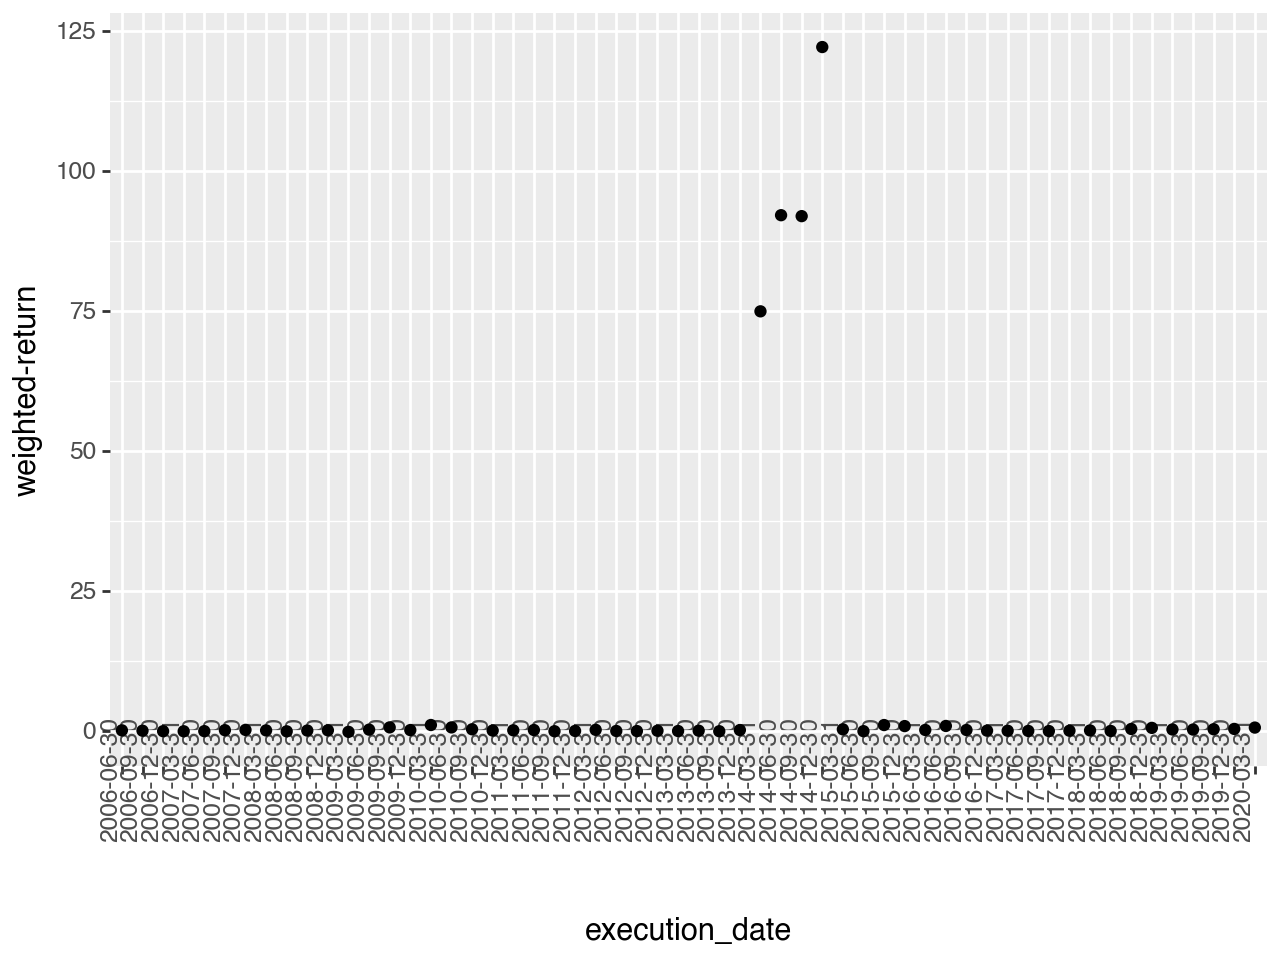

In [44]:
ggplot(test_results_final_tree) + geom_point(aes(x = "execution_date", y = "weighted-return")) + theme(axis_text_x = element_text(angle = 90, vjust = 0.5, hjust=1))



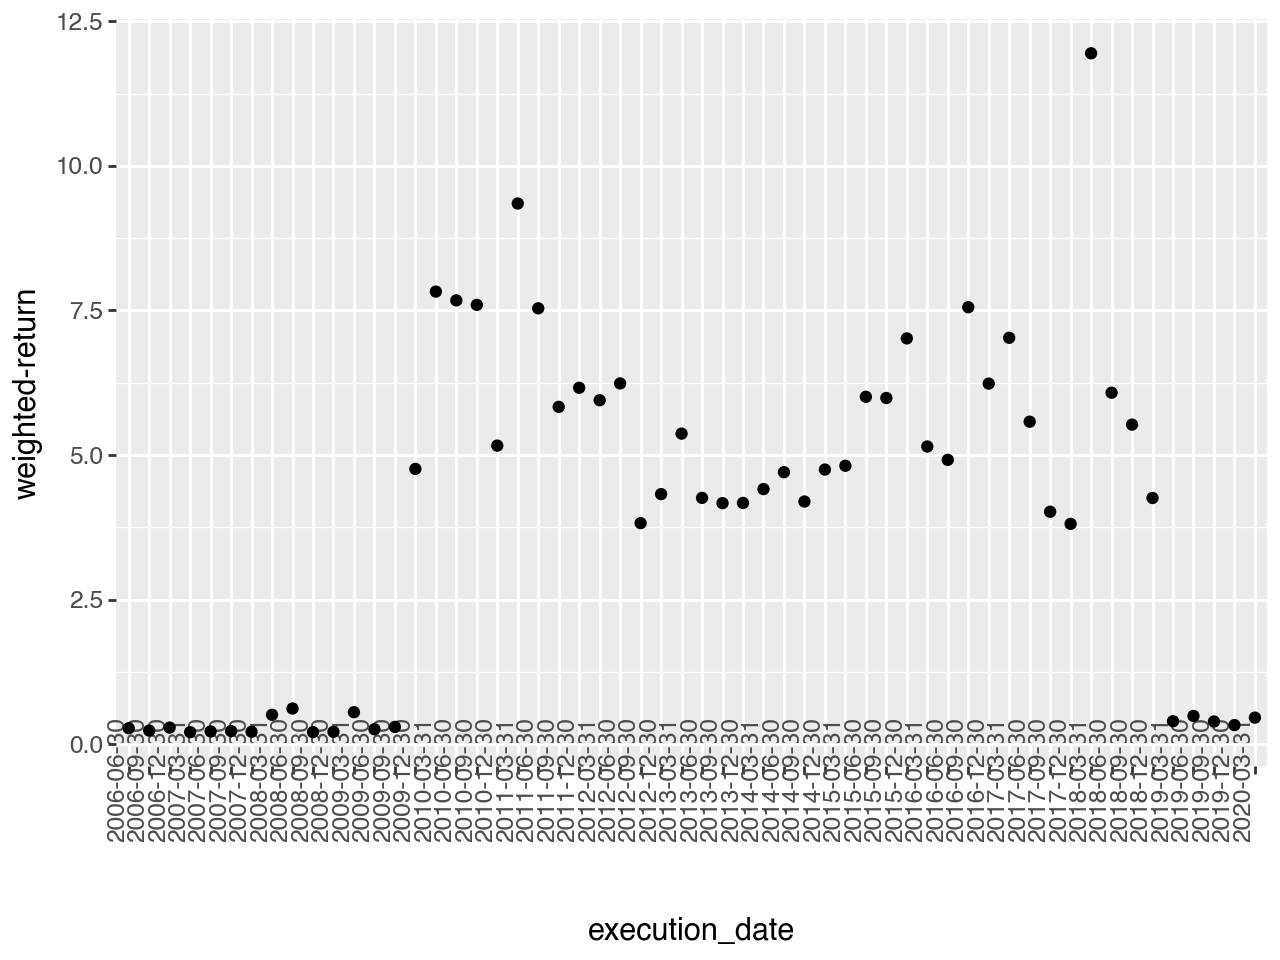

In [45]:
ggplot(train_results_final_tree) + geom_point(aes(x = "execution_date", y = "weighted-return")) + theme(axis_text_x = element_text(angle = 90, vjust = 0.5, hjust=1))


We have trained the first models for all the periods for you, but there are a lot of things which may be wrong or can be improved. Some ideas where you can start:
* Try to see if there is any kind of data leakage or suspicious features
* If the training part is very slow, try to see how you can modify it to execute faster tests
* Try to understand if the algorithm is learning correctly
* We are using a very high level metric to evaluate the algorithm so you maybe need to use some more low level ones
* Try to see if there is overfitting
* Try to see if there is a lot of noise between different trainings
* To simplify, why if you only keep the first tickers in terms of Market Cap?
* Change the number of quarters to train in the past

This function can be useful to compute the feature importance:

In [46]:
def draw_feature_importance(model,top = 15):
    fi = model.feature_importance()
    fn = model.feature_name()
    feature_importance = pd.DataFrame([{"feature":fn[i],"imp":fi[i]} for i in range(len(fi))])
    feature_importance = feature_importance.sort_values("imp",ascending = False).head(top)
    feature_importance = feature_importance.sort_values("imp",ascending = True)
    plot = ggplot(feature_importance,aes(x = "feature",y  = "imp")) + geom_col(fill = "lightblue") + coord_flip() +  scale_x_discrete(limits = feature_importance["feature"])
    return plot


In [47]:
from scipy.stats import lognorm
import matplotlib.pyplot as plt

# ***Part 2: Solution***

Una vez vista el código propuesto, el objetivo es encontrar donde esta fallando el modelo. Un weighted-return de 0,3, significa que nuestro portfolio mejora un 30% al SP500 en el proximo año, lo cual es ya un buen resultado, el problema es que nuestro modelo en train tiene muchos weighted-return muy altos, e.g. valores de 5 significarian mejorar un 500% lo cual hace sospechar que el modelo no es correcto

El primer paso en modelos de ML es definir un baseline sin ML que sirva de referencia, si no mejoramos ese baseline, no esta justificado el uso de ML.

### ***Baseline***

In [48]:
test_results_final_tree.head()

,binary_logloss,weighted-return,n_trees,execution_date
39,0.759610,0.099404,39,2006-06-30
39,0.730303,0.035528,39,2006-09-30
39,0.715078,-0.052195,39,2006-12-30
39,0.710833,-0.067471,39,2007-03-31
39,0.711701,-0.045395,39,2007-06-30


In [49]:
def merge_against_benchmark(metrics_df, all_predicted_tickers, top_n_market_cap= 500):
    all_predicted_tickers = all_predicted_tickers.sort_values(["execution_date", "Market_cap"], ascending = False)
    all_predicted_tickers["rank"] = all_predicted_tickers.groupby(["execution_date"]).cumcount()
    all_predicted_tickers_top_mc = all_predicted_tickers[all_predicted_tickers["rank"] <= 500]
    baseline = all_predicted_tickers_top_mc.groupby("execution_date")["diff_ch_sp500"].mean().reset_index()
    baseline = baseline.rename(columns ={"diff_ch_sp500":"diff_ch_sp500_baseline"})
    baseline["execution_date"] = baseline["execution_date"].astype(str)
    metrics_df =pd.merge(metrics_df, baseline, on="execution_date")
    return metrics_df

In [50]:
test_results_final_tree = merge_against_benchmark(test_results_final_tree, all_predicted_tickers)

In [51]:
test_results_final_tree.head()

,binary_logloss,weighted-return,n_trees,execution_date,diff_ch_sp500_baseline
0,0.759610,0.099404,39,2006-06-30,0.049213
1,0.730303,0.035528,39,2006-09-30,0.067796
2,0.715078,-0.052195,39,2006-12-30,0.068473
3,0.710833,-0.067471,39,2007-03-31,0.048029
4,0.711701,-0.045395,39,2007-06-30,0.077166


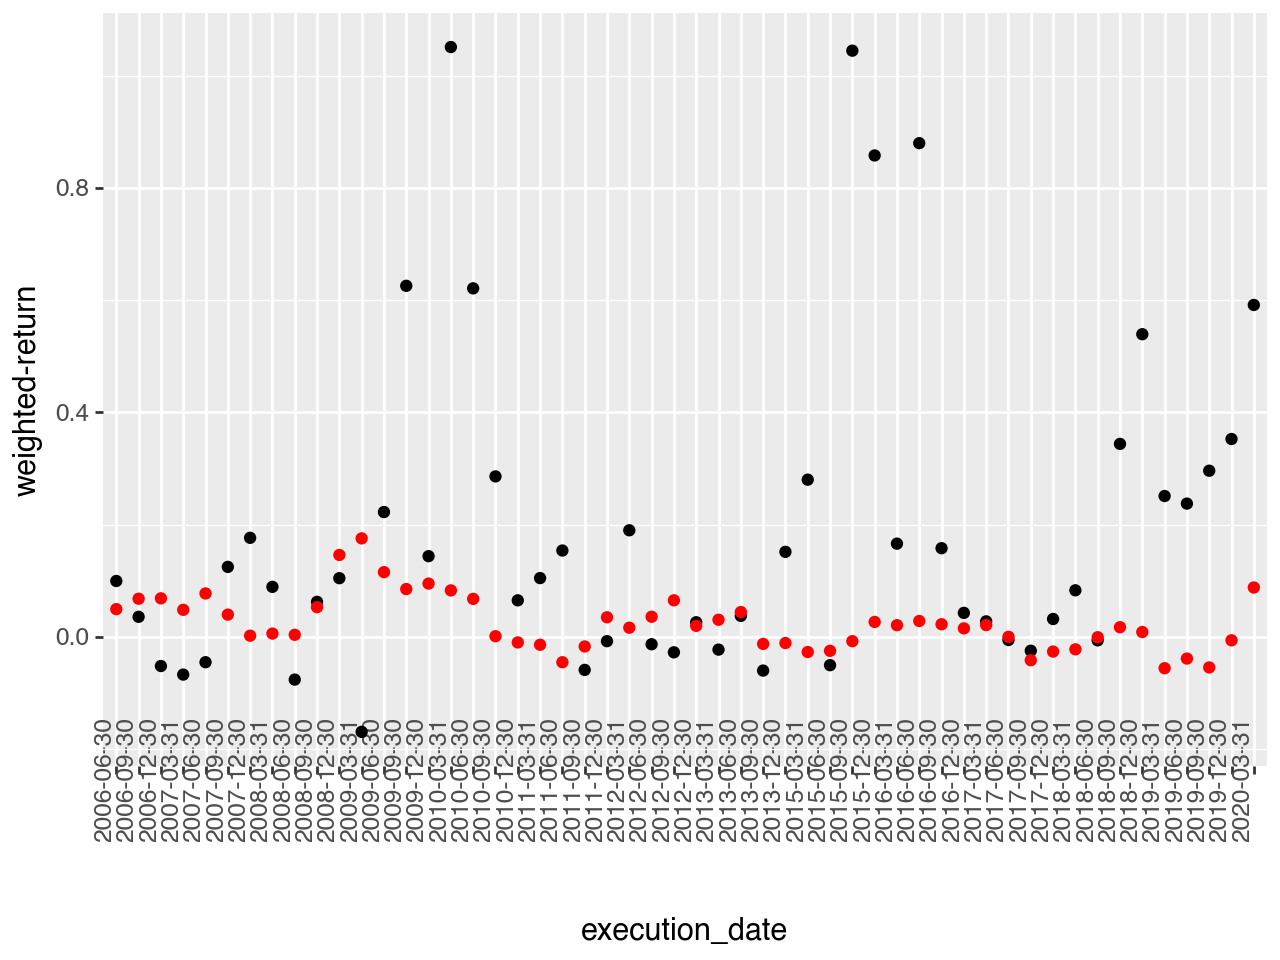

In [52]:
(ggplot(test_results_final_tree[test_results_final_tree["weighted-return"]<2])
+ geom_point(aes(x = "execution_date", y = "weighted-return"), color='black')
+ geom_point(aes(x= "execution_date", y ="diff_ch_sp500_baseline"), color="red")
+ theme(axis_text_x = element_text(angle = 90, vjust = 0.5, hjust=1))
)

Baseline: Puntos rojos

La función `merge_against_benchmark` crea el baseline seleccionando para cada `execution_date`las 500 acciones con mayor capitalización de mercado (Market_cap)  y calculando el rendimiento promedio (`diff_ch_sp500` --> en 1 año) de las acciones seleccionadas vs S&P500

% de periodos en los que modelo es mejor que baseline:

In [53]:
periods_better_than_baseline = len(test_results_final_tree[test_results_final_tree['weighted-return']>test_results_final_tree["diff_ch_sp500_baseline"]])/len(test_results_final_tree)
print(f"{periods_better_than_baseline *100:.2f}")

69.64


Rendimiento de baseline vs modelo

In [54]:
test_results_final_tree["weighted-return"].median()

0.11454718271321802

In [55]:
test_results_final_tree["diff_ch_sp500_baseline"].median()

0.015525563344158869

In [56]:
test_results_final_tree["weighted-return"].mean()

6.979676945548215

In [57]:
test_results_final_tree["diff_ch_sp500_baseline"].mean()

0.022159133577893696

Comparando con el baseline, el rendimiento del modelo tiene una mediana x10, lo cual es una mejora brutal y nos tiene que hacer sospechar. Tenemos que averiguar si el modelo esta realmente **aprendiendo y generalizando** o esta haciendo overfitting. Una herramienta muy útil son las curvas de aprendizaje en train y test y ver como evoluciona la metrica que definamos con el aumento de arboles. En este caso, la metrica que nos interesa minimizar es binary_logloss.

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_learning_curves(on_execution_date):
    if on_execution_date not in all_results:
        raise ValueError("No hay datos para execution_date: {on_execution_date}")
    
    eval_result = all_results[on_execution_date]

    n_trees =range(len(eval_result["training"]["binary_logloss"]))
    logloss_train = eval_result["training"]["binary_logloss"]
    logloss_test = eval_result["valid_0"]["binary_logloss"]

    sns.set_style("whitegrid")
    plt.figure(figsize=(12,6))

    plt.plot(n_trees, logloss_train,
             color="#1f77b4",
             marker="o",
             linestyle="-",
             linewidth = 1,
             markersize=3,
              label="train")
    
    plt.plot(n_trees, logloss_test,
             color="#ff7f0e",
             marker="s",
             linestyle="-",
             linewidth=1,
             markersize=3,
             label="validation")
    
    plt.title(f"Learning curves on {on_execution_date}")
    plt.xlabel("Number of trees")
    plt.ylabel("Binary LogLoss")

    
    plt.legend(loc="upper right", frameon= True)
    #plt.ylim(min(min(logloss_train), min(logloss_test)) * 0,95,
    #        max(max(logloss_train), max(logloss_test)) *1.05)
    
    plt.ylim(min(min(logloss_train), min(logloss_test)) * 0.95, 
            max(max(logloss_train), max(logloss_test)) * 1.05)
    plt.tight_layout()
    plt.show()

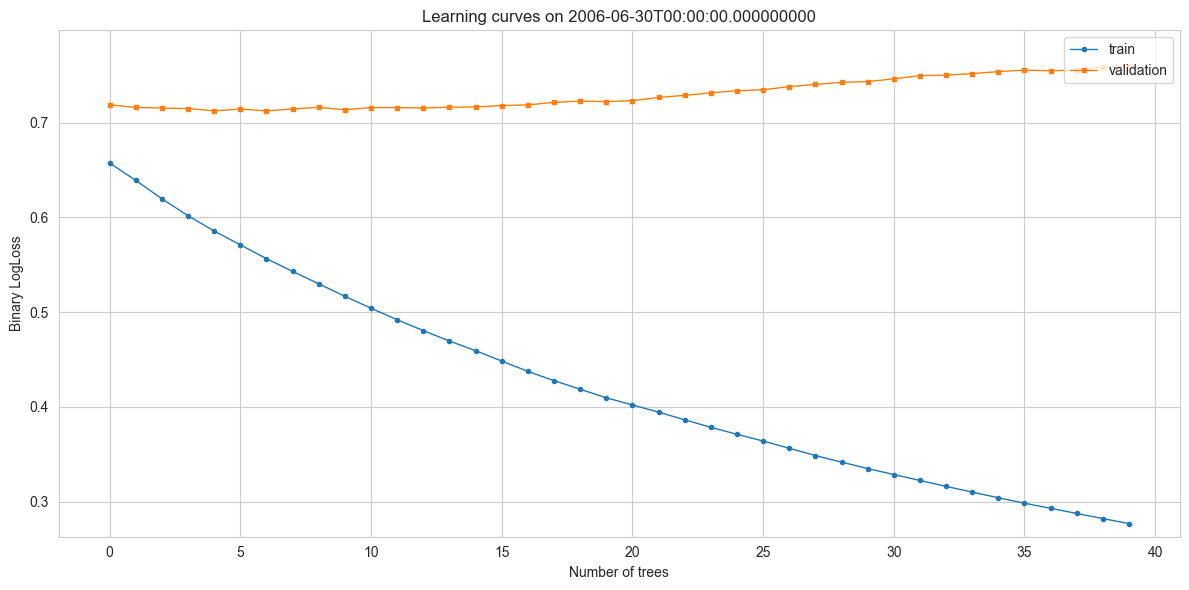

In [60]:
example=execution_dates[4]
plot_learning_curves(example)

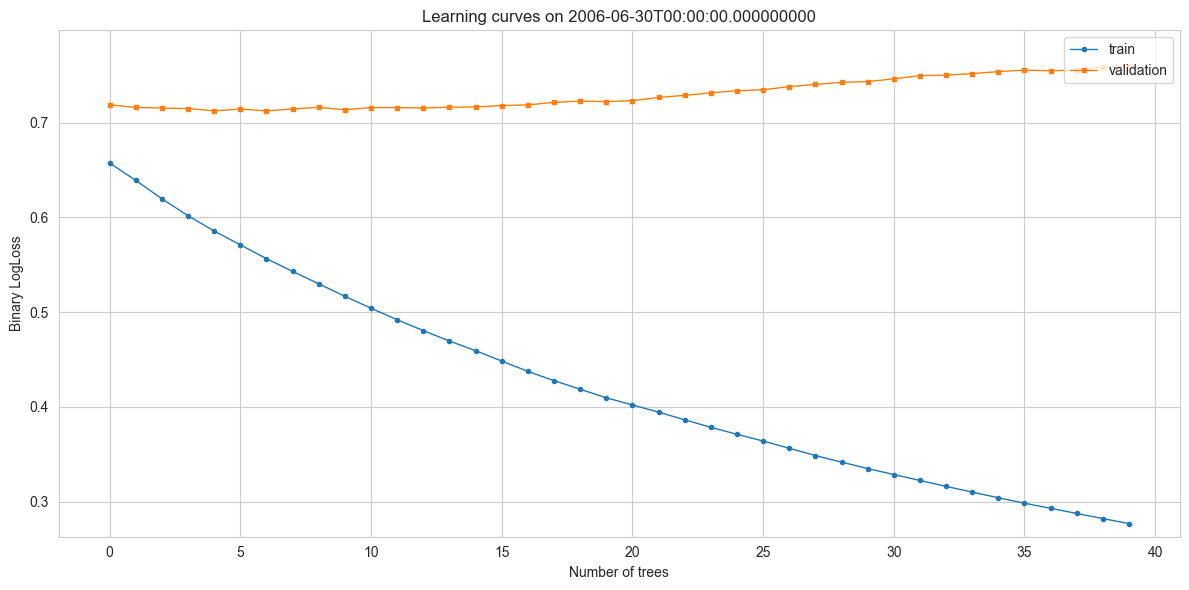

In [61]:
example2=execution_dates[14]
plot_learning_curves(example)

Esta función nos da una idea de lo que esta pasando, el error en train disminuye a medida que aumentan los arboles, comportamiento que no se ve en test. La brecha entre train y test es enorme, indicativo claro de overfitting. Como primer paso esta bien, pero lo suyo seria ver el rendimiento de todos los `execution_date` en una misma visualización, ya que tenemos 1 modelo por cada execution_date. Guille nos propuso en la solución un plot muy interesante

In [117]:
def plot_learning_curves_box(data, ylim=None):
    plt.style.use('ggplot')
    fig, ax = plt.subplots(figsize=(12,6))

    box_data = [
        data[data['n_trees_cat'] == tree]['norm_binary_logloss'].values
        for tree in sorted(data['n_trees_cat'].unique())
    ]

    box = ax.boxplot(
        box_data,
        patch_artist=True,
        widths=0.6,
        medianprops={'color':'white'}
    )

    for patch in box['boxes']:
        patch.set_facecolor('#1f77b4')

    ax.set_xticks(range(1, len(box_data) + 1))
    ax.set_xticklabels(sorted(data['n_trees_cat'].unique()))
    ax.set_title("Normalized metric evolution per iteration")
    ax.set_xlabel("Number of trees")
    ax.set_ylabel("norm_binary_logloss")
    ax.axhline(0, color='black', linestyle='--', linewidth=1)

    if ylim is not None:
        ax.set_ylim(ylim)

    plt.tight_layout()
    plt.show()

In [63]:
def return_learning_curve(set_name):
    lc = pd.concat([
        pd.DataFrame({
            'n_trees':range(len(results[set_name]['binary_logloss'])),
            'binary_logloss': results[set_name]['binary_logloss'],
            'execution_date':date
        }) for date, results in all_results.items() if set_name in results
    ])

    lc['norm_binary_logloss'] = lc.groupby('execution_date')['binary_logloss'].transform(lambda x: (x - x.iloc[0])/x.iloc[0])


    lc['n_trees_cat'] = pd.Categorical(lc['n_trees'], categories=sorted(lc['n_trees'].unique()))

    return lc

    n_trees  binary_logloss execution_date  norm_binary_logloss n_trees_cat
0         0        0.657505     2006-06-30             0.000000           0
1         1        0.639193     2006-06-30            -0.027851           1
2         2        0.619754     2006-06-30            -0.057415           2
3         3        0.601840     2006-06-30            -0.084660           3
4         4        0.585715     2006-06-30            -0.109185           4
..      ...             ...            ...                  ...         ...
35       35        0.622280     2020-03-31            -0.089537          35
36       36        0.621630     2020-03-31            -0.090487          36
37       37        0.620799     2020-03-31            -0.091703          37
38       38        0.619807     2020-03-31            -0.093155          38
39       39        0.618926     2020-03-31            -0.094444          39

[2240 rows x 5 columns]


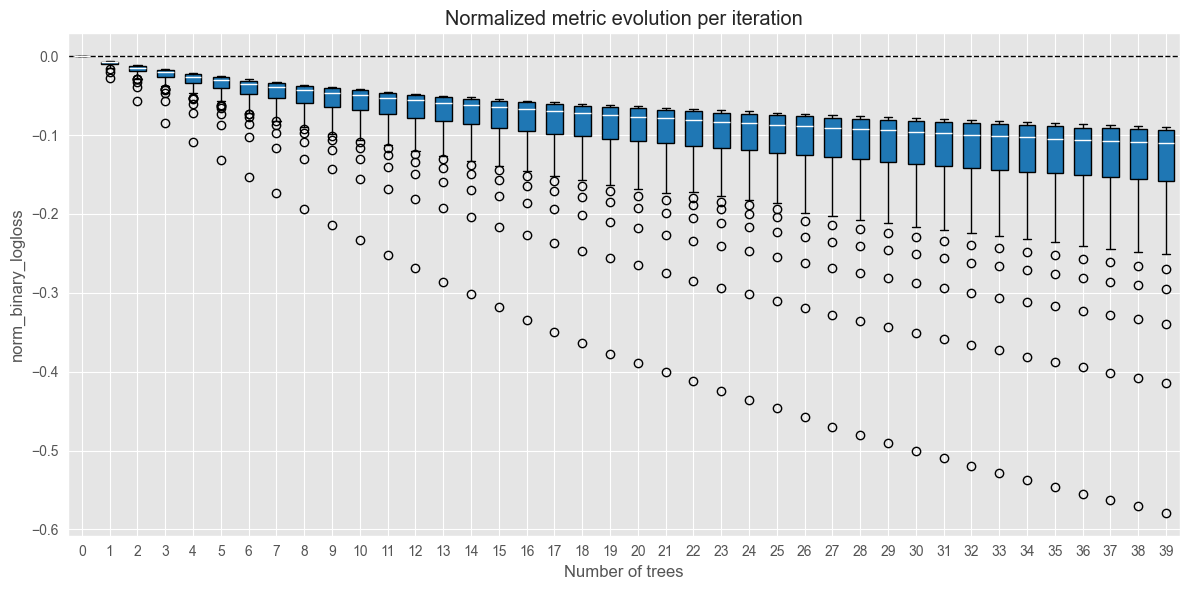

In [ ]:
train_lc = return_learning_curve('training')
test_lc = return_learning_curve('valid_0')
print(train_lc)
plot_learning_curves_box(train_lc)

En train vemos que al aumentar el número de árboles, la función de perdida es baja, la mediana baja moderadamente, pero hay outliers que bajan muchisimo

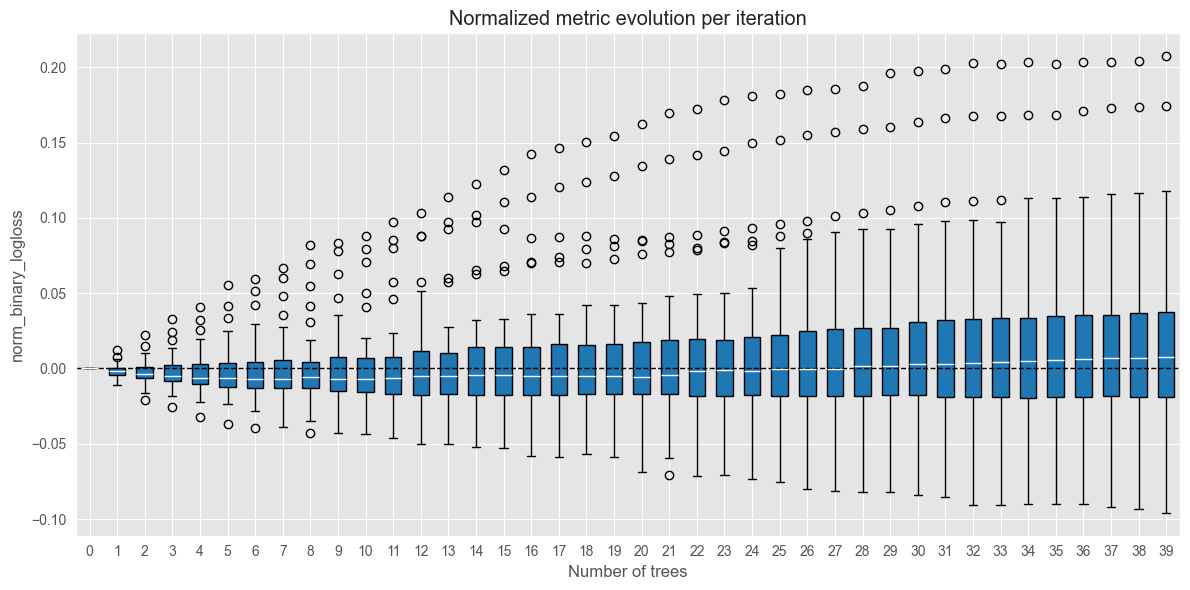

In [ ]:
plot_learning_curves_box(test_lc)

En test, la mediana de la logloss normalizada se mantiene constante, lo cual es malo porque no esta aprendiendo. Además hay outliers que mejoran bastante, pero hay otros outliers que empeoran mucho más, seguramente porque estamos haciendo overfitting. Vamos a hacer zoom en las learning curves de test

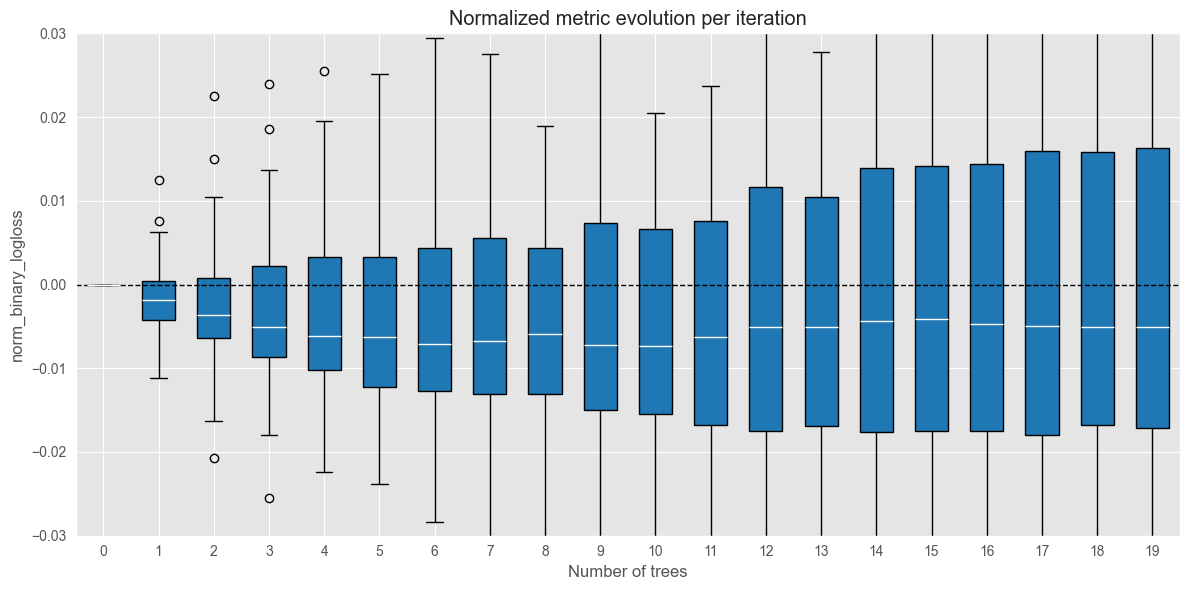

In [66]:
test_lc_filtered = test_lc[test_lc["n_trees"] <= 19]
plot_learning_curves(test_lc_filtered, ylim=(-0.03, 0.03))

Se puede ver que hasta el arbol 10, la mediana baja un poco y despues vuelve a subir

Cuando vemos que un modelo es tan complejo y tiene tanto overfitting, hay que intentar simplificar mucho el modelo y apartir de ahi añadir capas de complejidad.

En particular vamos a probar a modificar estos 4 hiperparametros:

* learning_rate: controla la contribución de un arbol al siguiente

* n_estimators : numero de arboles

* path_smooth: suaviza las predicciones en los nodos terminales para evitar el sobreajuste, especialmente en hojas con pocas muestras.

* num_leaves: cuantas hojas tiene cada arbol

In [67]:
params = {
    "random_state":1,
    "verbosity": -1,
    "n_jobs":10,
    "objective": "binary",
    "metric": "binary_logloss",
    "learning_rate": 10e-3,
    "path_smooth":0.2,
    "n_estimators":20
}

all_results = {}
all_predicted_tickers_list = []
all_models = {}

for execution_date in execution_dates:
    print(execution_date)
    all_results,all_predicted_tickers_list,all_models,model,X_train,X_test = run_model_for_execution_date(execution_date,all_results,all_predicted_tickers_list,all_models,n_trees,False)
all_predicted_tickers = pd.concat(all_predicted_tickers_list) 

2005-06-30T00:00:00.000000000
2005-09-30T00:00:00.000000000
2005-12-30T00:00:00.000000000
2006-03-31T00:00:00.000000000
2006-06-30T00:00:00.000000000
2006-09-30T00:00:00.000000000
2006-12-30T00:00:00.000000000
2007-03-31T00:00:00.000000000
2007-06-30T00:00:00.000000000
2007-09-30T00:00:00.000000000
2007-12-30T00:00:00.000000000
2008-03-31T00:00:00.000000000
2008-06-30T00:00:00.000000000
2008-09-30T00:00:00.000000000
2008-12-30T00:00:00.000000000
2009-03-31T00:00:00.000000000
2009-06-30T00:00:00.000000000
2009-09-30T00:00:00.000000000
2009-12-30T00:00:00.000000000
2010-03-31T00:00:00.000000000
2010-06-30T00:00:00.000000000
2010-09-30T00:00:00.000000000
2010-12-30T00:00:00.000000000
2011-03-31T00:00:00.000000000
2011-06-30T00:00:00.000000000
2011-09-30T00:00:00.000000000
2011-12-30T00:00:00.000000000
2012-03-31T00:00:00.000000000
2012-06-30T00:00:00.000000000
2012-09-30T00:00:00.000000000
2012-12-30T00:00:00.000000000
2013-03-31T00:00:00.000000000
2013-06-30T00:00:00.000000000
2013-09-30

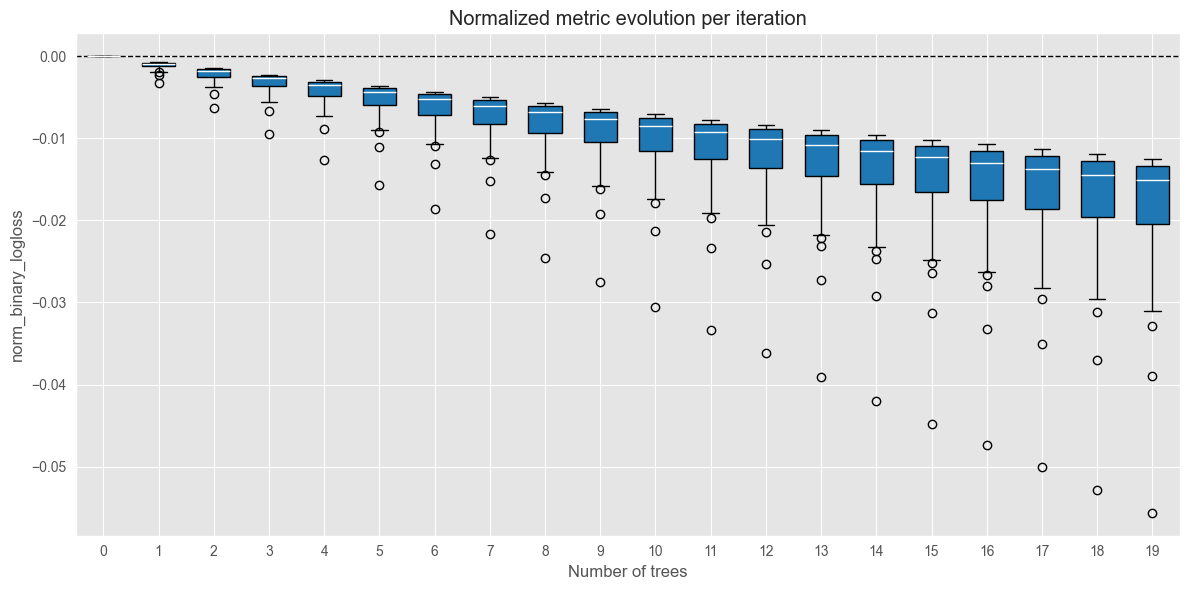

In [ ]:
train_lc2 = return_learning_curve('training')
test_lc2 = return_learning_curve('valid_0')
plot_learning_curves_box(train_lc2)

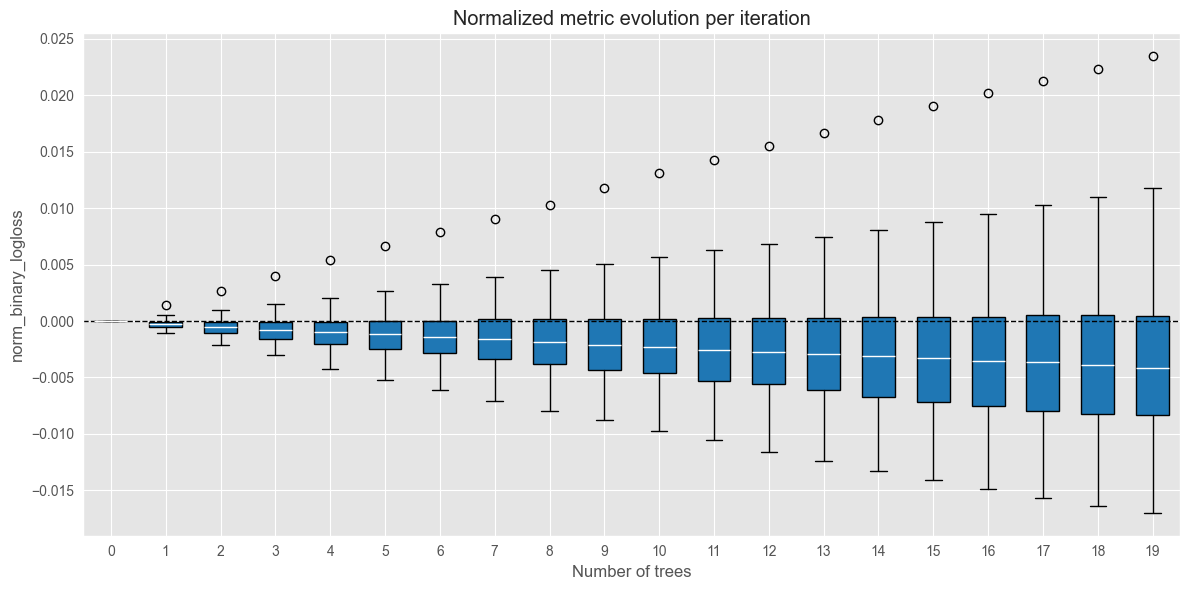

In [ ]:
plot_learning_curves_box(test_lc2)

Pese a seguir haciendo overfitting, en el test set la logloss disminuye a medida que aumenta el numero de arboles, a diferencia del anterior entrenamiento que a partir del 10º arbol volvia a aumentar. Llegados a este punto, aunque el modelo siga haciendo overfitting, vamos a considerar que está más o menos "generalizando" y continuaremos con el paso de Feature Importance, uno de los objetivos principales de este modulo

### ***Feature importance***

Feature importance nos srive para: 

* Diagnosticar si alguna de las features tiene una importancia extremadamente alta --> sintoma de data leakage

* Detectar las features más importantes y reentrenar solo con esas (modelo menos complejo, menos computo, predicciones más rapidas)

* Entender los factores que hacen que el modelo prediga lo que esta prediciendo

Función para calcular la media de Feature importance de todos los modelos entrenados 

In [70]:
def plot_average_feature_importance(all_models, top=15):
    all_dfs = []
    
    for execution_date in all_models:
        model = all_models[execution_date]
        fi = model.feature_importance(importance_type="gain")
        fn = [str(f) for f in model.feature_name()]
        df = pd.DataFrame({"feature": fn, "imp": fi})
        all_dfs.append(df)
    

    combined = pd.concat(all_dfs)
    avg_imp = combined.groupby("feature")["imp"].mean().reset_index()
    avg_imp["imp_pct"] = (avg_imp["imp"] / avg_imp["imp"].sum()) * 100  # Porcentaje
    

    avg_imp = avg_imp.sort_values("imp_pct", ascending=False).head(top)
    
    fig, ax = plt.subplots(figsize=(12, 7))
    bars = ax.barh(avg_imp["feature"], avg_imp["imp_pct"], color="skyblue")
    ax.invert_yaxis()
    ax.set_title("Average Feature Importance (All Dates)")
    ax.set_xlabel("Average Importance (%)")
    plt.show()

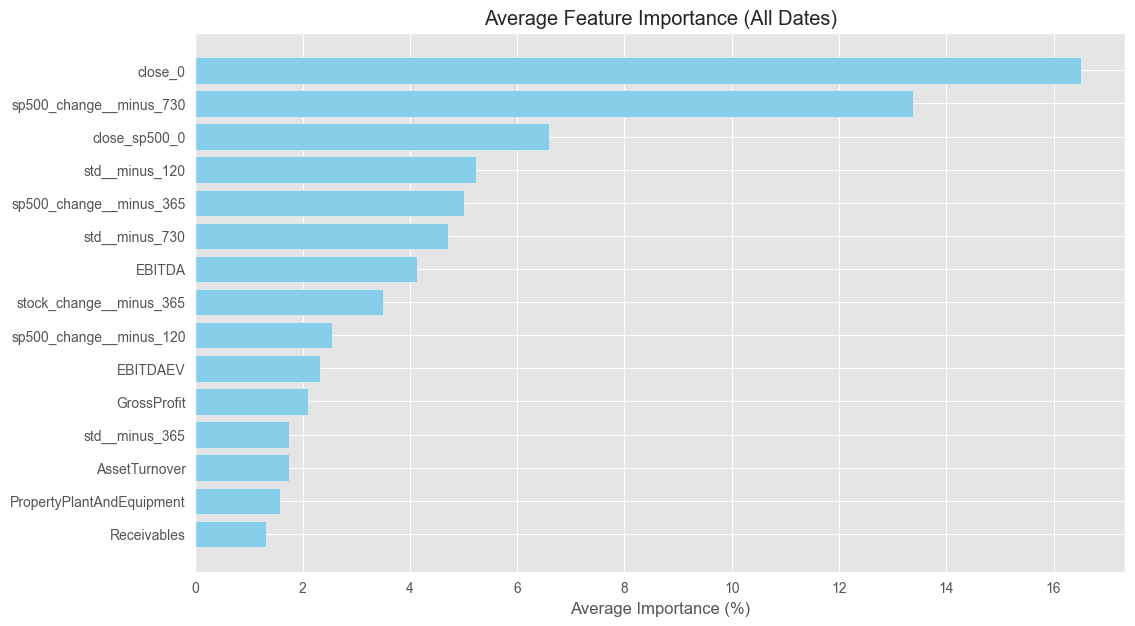

In [71]:
plot_average_feature_importance(all_models, top=15)

Las features más importantes son: 

* close_0 : precio de la acción en la execution_date

* sp500_change_minus_730 : % change of the SP500 in the last 2 years

* close_sp500_o : precio de SP500 en execution_date

Normalmente, el feature importance para arboles no se usa mucho ya que se basan en el numero de veces que se ha utilizado una variable para hacer splits en el arbol, lo cual tiene un sesgo muy alto a variables con cardinalidad alta (aunque no sea importante esa feature tiene mas probabilidad de ser escogida para hacer un split simplemente por su cardinalidad.)

Son mucho más interesantes otros metodos que son agnosticos al modelo que utilicemos como:

* Feature permutation: En el conjunto de test, hago una permutacion aleatoria de los valores de una feature concreta y veo la diferencia entre la predicción con la feature randomizada y sin randomizar, calculando esa diferencia.

    Diferencia grande --> Feature ***importante***

    Diferencia pequeña --> Feature no es importante

    Problema: No nos dice la dirección de la importancia

    

* SHAP: Para cada sample, mide cuanto ha contribuido cada feature a la predicción comparando con la predicción media del modelo.

Primero, vamos a utilizar feature permutation

In [72]:
import sklearn
from sklearn.inspection import permutation_importance

def train_model(train_set, test_set, compute_importance = False):
    global params
    columns_to_remove = get_columns_to_remove()

    X_train = train_set.drop(columns=columns_to_remove, errors="ignore")
    X_test = test_set.drop(columns=columns_to_remove, errors="ignore")

    y_train = train_set["target"]
    y_test = test_set["target"]

    model = lgb.LGBMClassifier(**params)
    lgb_train = lgb.Dataset(X_train, label=y_train)
    lgb_test = lgb.Dataset(X_test, label=y_test, reference=lgb_train)

    eval_result={}
    model.fit(X_train, y_train, eval_set=[(X_test, y_test), (X_train, y_train)],
              eval_metric=top_wt_performance, callbacks=[lgb.record_evaluation(eval_result)])
    if compute_importance:
        r = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=0)
        feature_names = X_test.columns
        df_permutation_importance = pd.DataFrame({'importance': r.importances_mean, 'feature': feature_names})
    else:
        df_permutation_importance = pd.DataFrame()
    
    return model, eval_result, X_train, X_test, df_permutation_importance


In [73]:
def run_model_for_execution_date(execution_date, all_results, all_predicted_tickers_list, all_models, include_nulls_in_test = False, compute_importance = False):
    global train_set
    global test_set
    global all_permutation_importances

    train_set, test_set = split_train_test_by_period(data_set, execution_date, include_nulls_in_test = include_nulls_in_test)
    train_size, _ = train_set.shape
    test_size, _ = test_set.shape
    model = None
    X_train = None
    X_test = None

    if train_size > 0 and test_size>0:
        model, evals_result, X_train, X_test, df_permutation_importance = train_model(train_set, test_set, compute_importance)
        if type(model)==lgb.sklearn.LGBMClassifier:
            model = model.booster_
        test_set['prob'] = model.predict(X_test)
        predicted_tickers = test_set.sort_values('prob', ascending=False)
        predicted_tickers["execution_date"] = execution_date
        all_results[(execution_date)] = evals_result
        all_models[(execution_date)] = model
        all_predicted_tickers_list.append(predicted_tickers)
        df_permutation_importance["execution_date"]= execution_date
        all_permutation_importances = pd.concat([all_permutation_importances, df_permutation_importance])


    return all_results, all_predicted_tickers_list, all_models, model, X_train, X_test 



El cálculo de la permutation importance es un poco lento. No tiene sentido calcularlo en cualquier periodo y por eso modificamos la función train_model_accross_periods para permitir el entrenamiento sólo en un subconjunto.

In [74]:
def train_model_accross_periods(train_period_frequency = 1, compute_importance = False):
    global all_results
    global all_predicted_tickers_list
    global all_models
    global all_predicted_tickers
    for i, execution_date in enumerate(execution_dates):
        if i%train_period_frequency==0:
            print(execution_date)
            all_results, all_predicted_tickers_list, all_models, model, X_train, X_test = run_model_for_execution_date(execution_date, all_results, all_predicted_tickers_list, all_models, False,compute_importance)

    all_predicted_tickers = pd.concat(all_predicted_tickers_list)

In [94]:
params = {
    "random_state":1,
    "verbosity": -1,
    "n_jobs":10,
    "objective": "binary",
    "metric": "binary_logloss",
    "learning_rate": 10e-3,
    "path_smooth":0.2,
    "n_estimators":20
}

all_results = {}
all_predicted_tickers_list = []
all_models = {}
all_permutation_importances = pd.DataFrame()

train_model_accross_periods(train_period_frequency=2, compute_importance=True)


2005-06-30T00:00:00.000000000
2005-12-30T00:00:00.000000000
2006-06-30T00:00:00.000000000
2006-12-30T00:00:00.000000000
2007-06-30T00:00:00.000000000
2007-12-30T00:00:00.000000000
2008-06-30T00:00:00.000000000
2008-12-30T00:00:00.000000000
2009-06-30T00:00:00.000000000
2009-12-30T00:00:00.000000000
2010-06-30T00:00:00.000000000
2010-12-30T00:00:00.000000000
2011-06-30T00:00:00.000000000
2011-12-30T00:00:00.000000000
2012-06-30T00:00:00.000000000
2012-12-30T00:00:00.000000000
2013-06-30T00:00:00.000000000
2013-12-30T00:00:00.000000000
2014-06-30T00:00:00.000000000
2014-12-30T00:00:00.000000000
2015-06-30T00:00:00.000000000
2015-12-30T00:00:00.000000000
2016-06-30T00:00:00.000000000
2016-12-30T00:00:00.000000000
2017-06-30T00:00:00.000000000
2017-12-30T00:00:00.000000000
2018-06-30T00:00:00.000000000
2018-12-30T00:00:00.000000000
2019-06-30T00:00:00.000000000
2019-12-30T00:00:00.000000000
2020-06-30T00:00:00.000000000
2020-12-30T00:00:00.000000000


Se define una función para visualizar las features más importantes

In [95]:
def plot_top_features(all_permutation_importances, top_n=10, figsize=(10, 6), title="Top 10 Características Más Importantes (Feature Importance)"):
 

    all_permutation_importances = all_permutation_importances.sort_values(["execution_date", "importance"], ascending=False)
    all_permutation_importances_sum = all_permutation_importances.groupby(["feature"])["importance"].mean().reset_index()
    all_permutation_importances_sum = all_permutation_importances_sum.sort_values("importance", ascending=False)
    all_permutation_importances_sum = all_permutation_importances_sum.head(top_n)


    plt.figure(figsize=figsize)
    sns.barplot(
        x="importance",
        y="feature",
        data=all_permutation_importances_sum,
        orient="h"
    )


    plt.title(title, fontsize=14)
    plt.xlabel("Importancia Media", fontsize=12)
    plt.ylabel("Característica", fontsize=12)
    plt.grid(axis="x", linestyle="--", alpha=0.4)


    for i, v in enumerate(all_permutation_importances_sum["importance"]):
        plt.text(v + 0.001, i, f"{v:.4f}", color='black', va="center")


    plt.tight_layout()
    plt.show()

In [96]:
all_permutation_importances = all_permutation_importances.sort_values(["execution_date", "importance"], ascending=False)


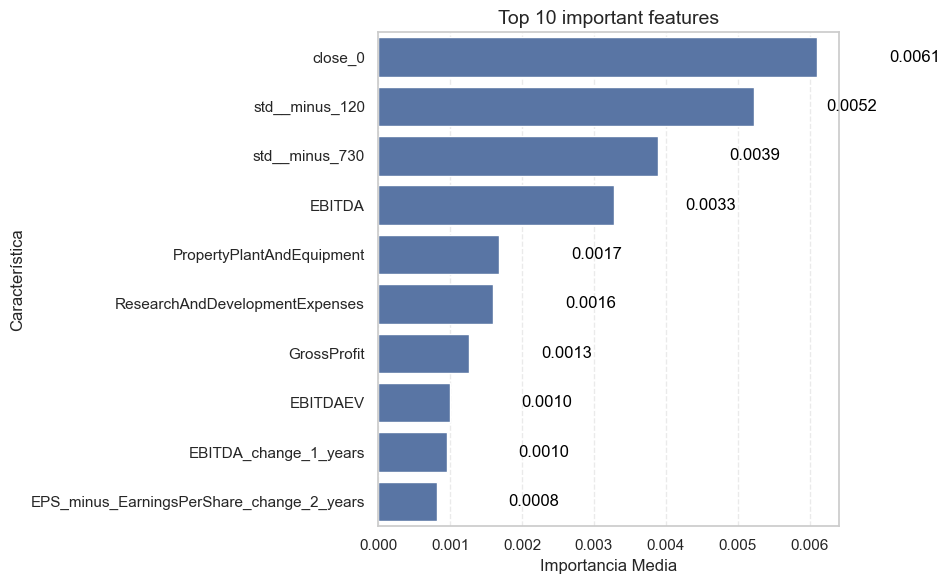

In [97]:
plot_top_features(all_permutation_importances, top_n=10, figsize=(10, 6), title="Top 10 important features")

Es curioso que `close_0` es la feature mas importante global, cuando lo unico que representa es el precio de la acción en el momento de la predicción. 

Se puede visualizar también para varios periodos, las 2 features más importantes, para asegurarnos de que close_0 se encuentra en muchos periodos y su valor tan alto no se debe solo a que en unos pocos periodos tiene un valor elevadisimo.

In [98]:
all_permutation_importances["rank"] = all_permutation_importances.groupby(["execution_date"]).cumcount()
r_all_permutation_importances = all_permutation_importances[all_permutation_importances["rank"] < 2]

In [99]:
r_all_permutation_importances = r_all_permutation_importances.sort_values("execution_date")

In [101]:
def plot_top_2_features(input_data):

    plt.figure(figsize=(20, 10)) 
    sns.set_theme(style="whitegrid")


    ax = sns.barplot(
        data=input_data,
        x="execution_date",
        y="importance",
        hue="feature",
        palette="bright",  
        saturation=0.9,
        dodge=False     
    )


    ax.xaxis.set_major_locator(plt.MaxNLocator(8))
    plt.xticks(
        rotation=45,
        ha="right",
        fontsize=12,        # Texto más grande
        fontweight="bold"   # Negrita para legibilidad
    )

    # Personalizar grosor y estilo
    plt.title("Top 2 Features por fecha (importance)", fontsize=16, pad=20, fontweight="bold")
    plt.xlabel("Date", fontsize=14, labelpad=15)
    plt.ylabel("Importance", fontsize=14, labelpad=15)


    plt.legend(
        bbox_to_anchor=(1.15, 1),
        loc="upper left",
        title="Características",
        title_fontsize=12,
        fontsize=12,
        frameon=True
    )


    ax.spines[["top", "right"]].set_visible(False)
    plt.grid(axis="y", linestyle="--", alpha=0.5, linewidth=1)

    plt.tight_layout()
    plt.show()

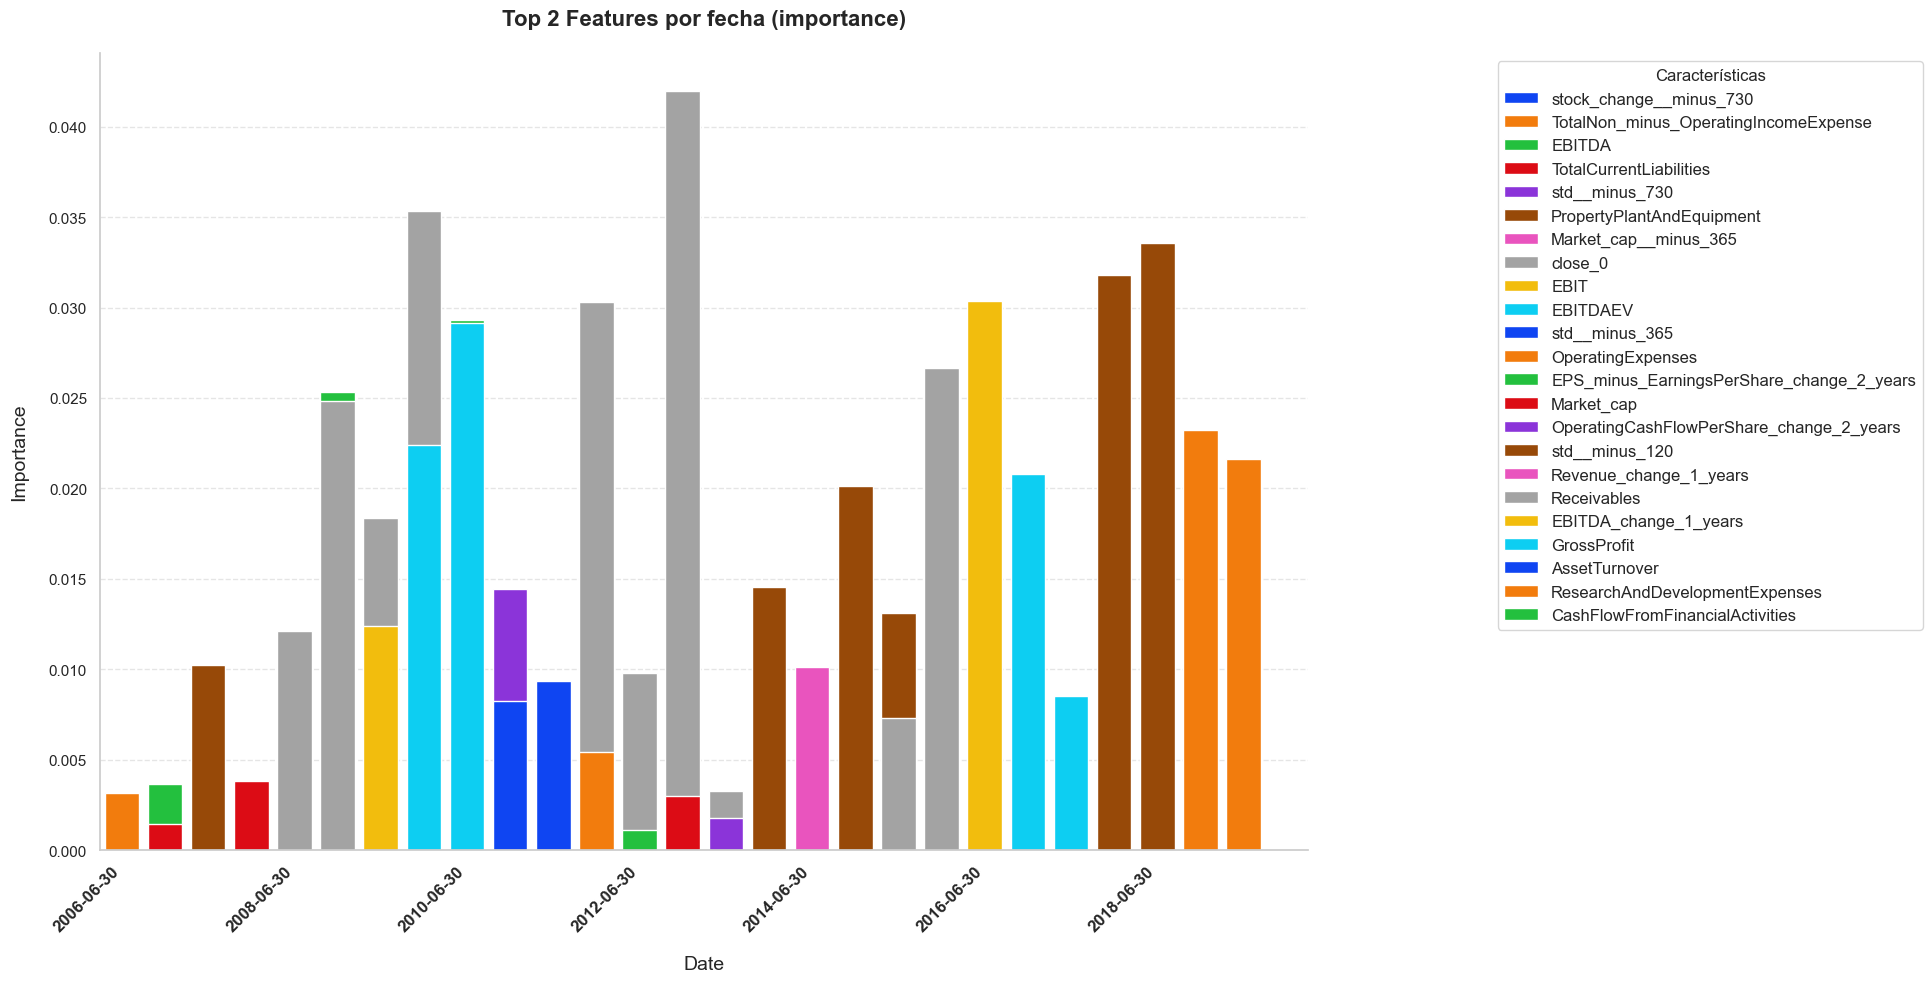

In [ ]:
plot_top_2_features(r_all_permutation_importances)

`close_0` aparece en muchos periodos y en los periodos en los que esta, es muy importante. Vamos a analizar por ejemplo `2015-12-30`, para entender mejor de donde puede venir esa importancia tan alta

In [103]:
all_permutation_importances[all_permutation_importances["execution_date"] == "2009-06-30" ]

,importance,feature,execution_date,rank
87,0.018389,close_0,2009-06-30,0
17,0.012394,EBIT,2009-06-30,1
105,0.006383,EBITEV,2009-06-30,2
98,0.004385,std__minus_120,2009-06-30,3
116,0.003281,EPS_minus_EarningsPerShare_change_2_years,2009-06-30,4
...,...,...,...,...
122,-0.006831,EBITDA_change_2_years,2009-06-30,128
113,-0.007442,ROC,2009-06-30,129
69,-0.008934,RetainedEarningsAccumulatedDeficit,2009-06-30,130
19,-0.010887,EBITDA,2009-06-30,131


Los tickers con mayor probabilidad en esta fecha son:

In [104]:
tickers = all_predicted_tickers[all_predicted_tickers["execution_date"] == "2009-06-30"].sort_values("prob", ascending=False)
tickers[["Ticker", "close_0", "prob"]].head(10)

,Ticker,close_0,prob
34343,PNC,38.810000,0.527120
33980,CM,50.208809,0.527120
36064,TM,75.530000,0.526818
35500,GS,147.440000,0.525329
34183,MBI,4.330000,0.524725
35930,EGY,4.230000,0.524725
35901,ROL,3.419259,0.524725
35957,INFY,4.597500,0.524725
35542,EW,5.669167,0.524725
34472,AAPL,5.086786,0.524725


Y los tickers con menor probabilidad en esta fecha son:

In [105]:
tickers = all_predicted_tickers[all_predicted_tickers["execution_date"] == "2009-06-30"].sort_values("prob", ascending=True)
tickers[["Ticker", "close_0", "prob"]].head(10)

,Ticker,close_0,prob
35083,CYCC,1900.080000,0.453509
35952,VBFC,75.200000,0.453509
35096,USEG,120.000000,0.453509
35909,TOWN,13.592233,0.454130
34237,PNFP,13.320000,0.454760
36056,SEED,46.400000,0.456984
33961,OPTT,1168.000000,0.456984
35706,MA,16.731000,0.457387
35747,TT,12.941984,0.458346
34760,ARNA,49.900000,0.458412


Algunos de los tickers con menor probabilidad tienen un `close_0`muy alto, como CYCC o OPTT

Vamos ahora a utilizar SHAP, podemos ver el feature importance de cada sample, en este caso de cada ticker

In [106]:
#!poetry add shap

In [107]:
import shap
def get_shap_values_for_ticker_execution_date(execution_date, ticker = None):
    
    date = np.datetime64(execution_date)
    model_ = all_models[date]
    fn = model_.feature_name()
    X_test = all_predicted_tickers[(all_predicted_tickers["execution_date"] == date)]
    if ticker is not None:
        X_test = X_test[X_test["Ticker"] == ticker]
    X_test["Ticker"] = X_test["Ticker"].astype("category")
    X_test = X_test.sort_values("Ticker")
    if ticker is not None:
        explainer = shap.Explainer(model_)
        shap_values = explainer(X_test[fn])
        

        if len(shap_values.shape) == 3:
            shap_values = shap_values[:, :, 1]
        else:
            shap_values = shap_values
    else:
        explainer = shap.Explainer(model_,X_test[fn])
        shap_values = explainer(X_test[fn])
    return shap_values

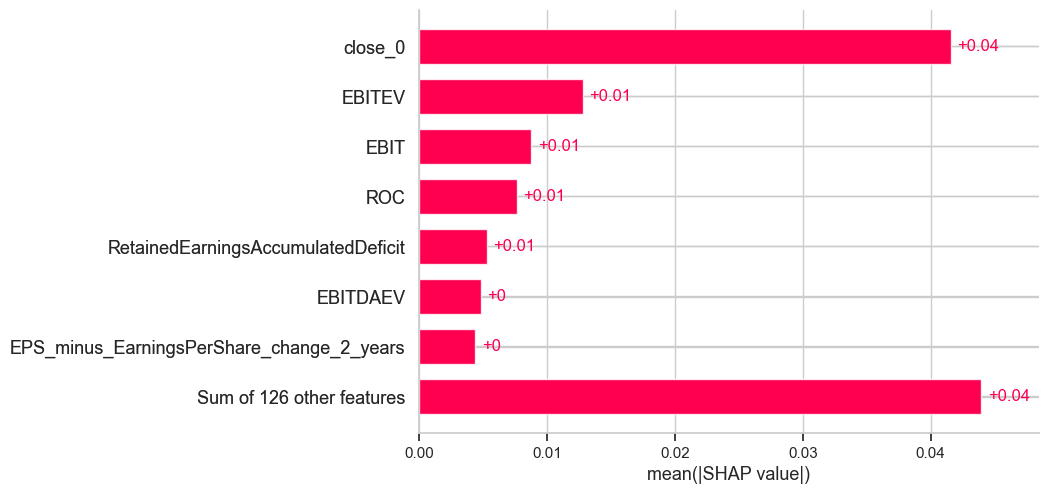

In [108]:
sv = get_shap_values_for_ticker_execution_date("2009-06-30T00:00:00.000000000")
shap.plots.bar(sv, max_display=8)

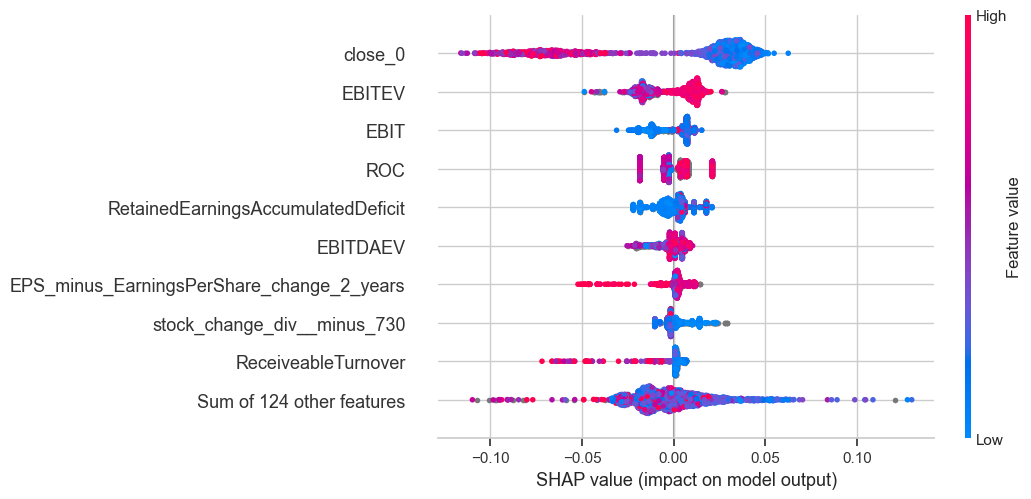

In [109]:
shap.plots.beeswarm(sv)

El modelo asigna mayor probabilidad a los tickers con menor valor en `close_0`(puntos azules) y menor probabilidad a los puntos con mayor valor en `close_0`.
Acciones con precio bajo tienen mayor probabilidad de ser elegidas por el modelo.

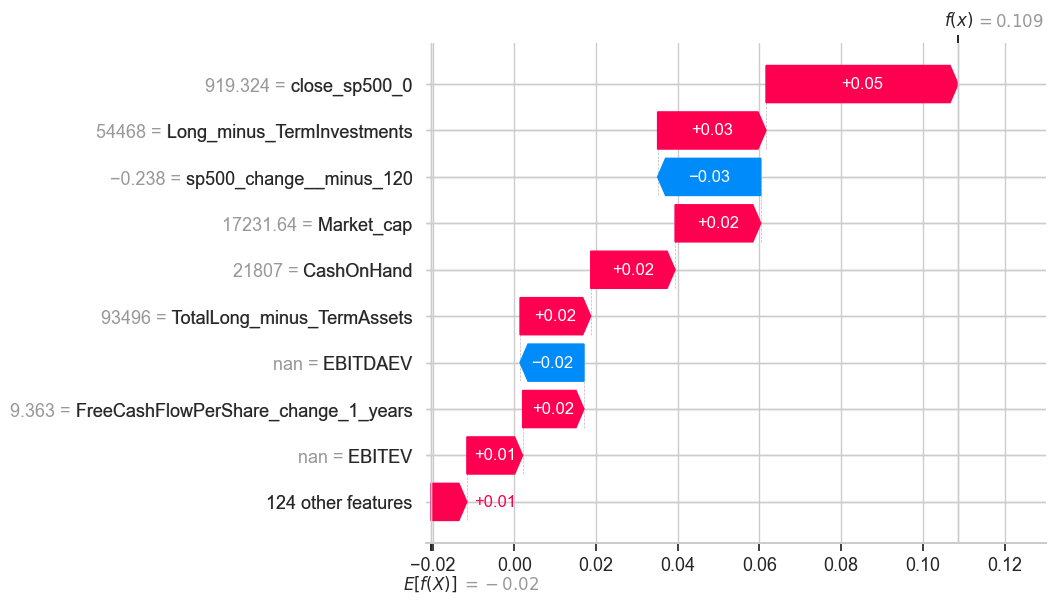

In [110]:
sv = get_shap_values_for_ticker_execution_date("2009-06-30T00:00:00.000000000", ticker = "PNC")
shap.plots.waterfall(sv[0])

Analizando el ticker "PNC" de los tickers con mayor probabilidad de esta fecha, vemos que close_0 da lugar a una mayor predicción y `close_0` es 38.8 en este caso

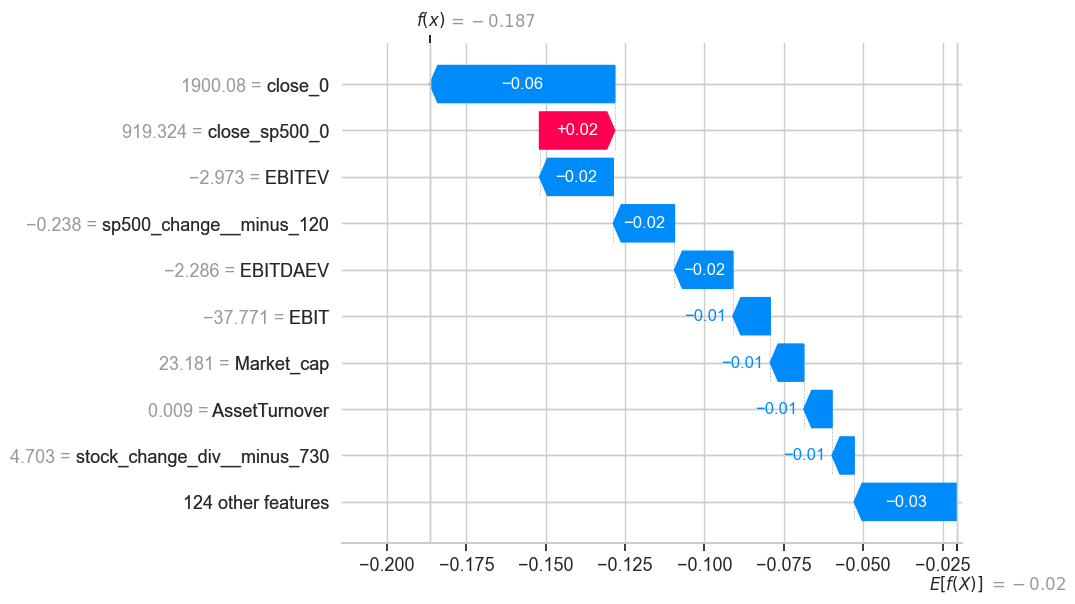

In [111]:
sv = get_shap_values_for_ticker_execution_date("2009-06-30T00:00:00.000000000", ticker = "CYCC")
shap.plots.waterfall(sv[0])

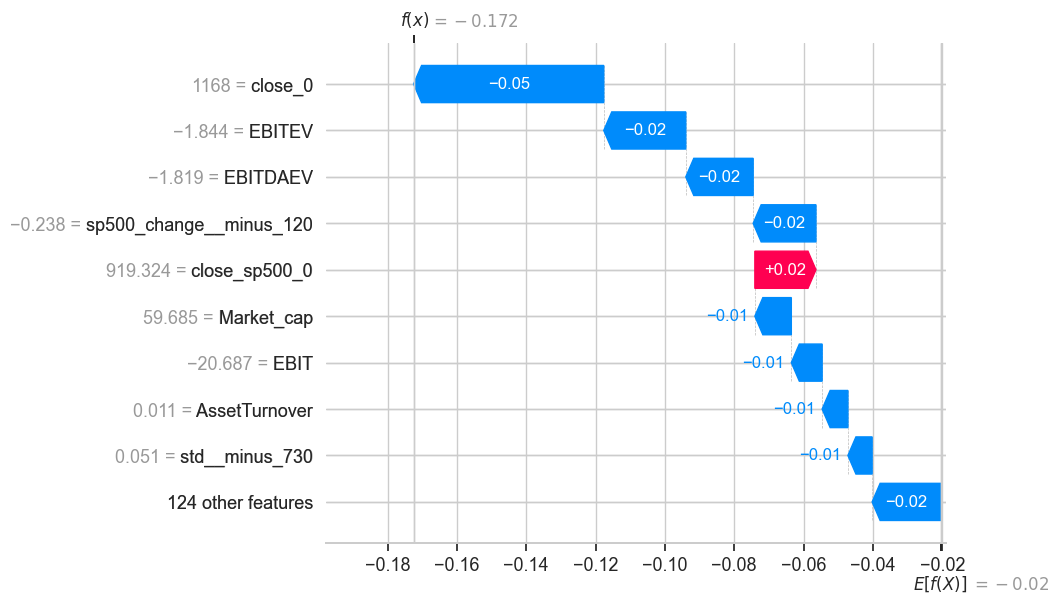

In [112]:
sv = get_shap_values_for_ticker_execution_date("2009-06-30T00:00:00.000000000", ticker = "OPTT")
shap.plots.waterfall(sv[0])

Sin embargo, analizando el ticker "CYCC" y "OPTT", dos de los ticker con probabilidad de esta fecha y con mayor close_0, vemos que close_0 da lugar a una menor predicción y `close_0` es 1900 y 1168 en este caso (lo vemos en tickers[["Ticker", "close_0", "prob"]].head(10), unas celdas más arriba). Hay un patron claro, cuanto mayor es el precio de la accion, menor es la probabilidad que asigna el modelo , pero, ¿porque ocurre esto? al final es solo un numero, no deberia influir.

En estos casos, el conocimiento sobre la materia es clave, ya que si buscamos en google la accion CYCC

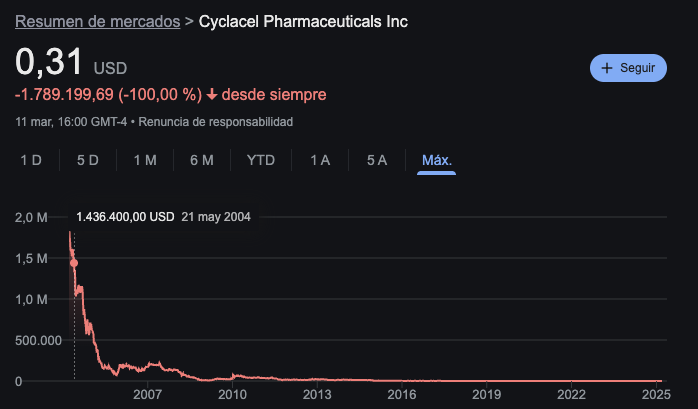

In [146]:
from IPython.display import Image
Image(filename="CYCC_stock.png")

Vemos que una acción de esta empresa valia 1.436.400 USD en 2004, esto es un precio altisimo para una acción, ¿es posible?

Este concepto esta relacionado con los splits, un concepto en el que empresas dividen sus acciones para tener mas, pero de menos valor. Es como si tengo un billete de 10€ y lo cambio por 2 billetes de 5€.

Un counter split es lo contrario, reducir el número de acciones y aumentar el precio por acción.

Por tanto, el valor de 1.436.400 USD en 2004, es el valor que tenia en su momento pero aplicando todos los counter splits posteriores. La serie se expresa en función del precio actual.


El modelo esta aprendiendo que las acciones con un precio muy alto en el pasado tienen en la actualidad un precio mucho más bajo.

Lo más sensato es eliminar esta feature y reentreanr, incluso podemos eliminar todas las technical features.

In [114]:
def get_columns_to_remove():
    columns_to_remove = [
                        "date",
                        "improve_sp500",
                        "Ticker",
                        "freq",
                        "set",
                        "close_sp500_365",
                        "close_365",
                        "stock_change_365",
                        "stock_change_div_365",
                        "stock_change_730",
                        "stock_change_div_730",
                        "sp500_change_365",
                        "sp500_change_730",
                        "diff_ch_sp500",
                        "diff_ch_avg_500",
                        "execution_date",
                        "target",
                        "index",
                        "quarter",
                        "std_730",
                        "count",
                        "stock_change_div__minus_365"
                        
    ]
    columns_to_remove += technical_features
    return columns_to_remove

In [115]:
params = {
    "random_state":1,
    "verbosity": -1,
    "n_jobs":10,
    "objective": "binary",
    "metric": "binary_logloss",
    "learning_rate": 10e-3,
    "path_smooth":0.2,
    "n_estimators":20
}

all_results = {}
all_predicted_tickers_list = []
all_models = {}
all_permutation_importances = pd.DataFrame()

train_model_accross_periods(train_period_frequency=1, compute_importance=False)

2005-06-30T00:00:00.000000000
2005-09-30T00:00:00.000000000
2005-12-30T00:00:00.000000000
2006-03-31T00:00:00.000000000
2006-06-30T00:00:00.000000000
2006-09-30T00:00:00.000000000
2006-12-30T00:00:00.000000000
2007-03-31T00:00:00.000000000
2007-06-30T00:00:00.000000000
2007-09-30T00:00:00.000000000
2007-12-30T00:00:00.000000000
2008-03-31T00:00:00.000000000
2008-06-30T00:00:00.000000000
2008-09-30T00:00:00.000000000
2008-12-30T00:00:00.000000000
2009-03-31T00:00:00.000000000
2009-06-30T00:00:00.000000000
2009-09-30T00:00:00.000000000
2009-12-30T00:00:00.000000000
2010-03-31T00:00:00.000000000
2010-06-30T00:00:00.000000000
2010-09-30T00:00:00.000000000
2010-12-30T00:00:00.000000000
2011-03-31T00:00:00.000000000
2011-06-30T00:00:00.000000000
2011-09-30T00:00:00.000000000
2011-12-30T00:00:00.000000000
2012-03-31T00:00:00.000000000
2012-06-30T00:00:00.000000000
2012-09-30T00:00:00.000000000
2012-12-30T00:00:00.000000000
2013-03-31T00:00:00.000000000
2013-06-30T00:00:00.000000000
2013-09-30

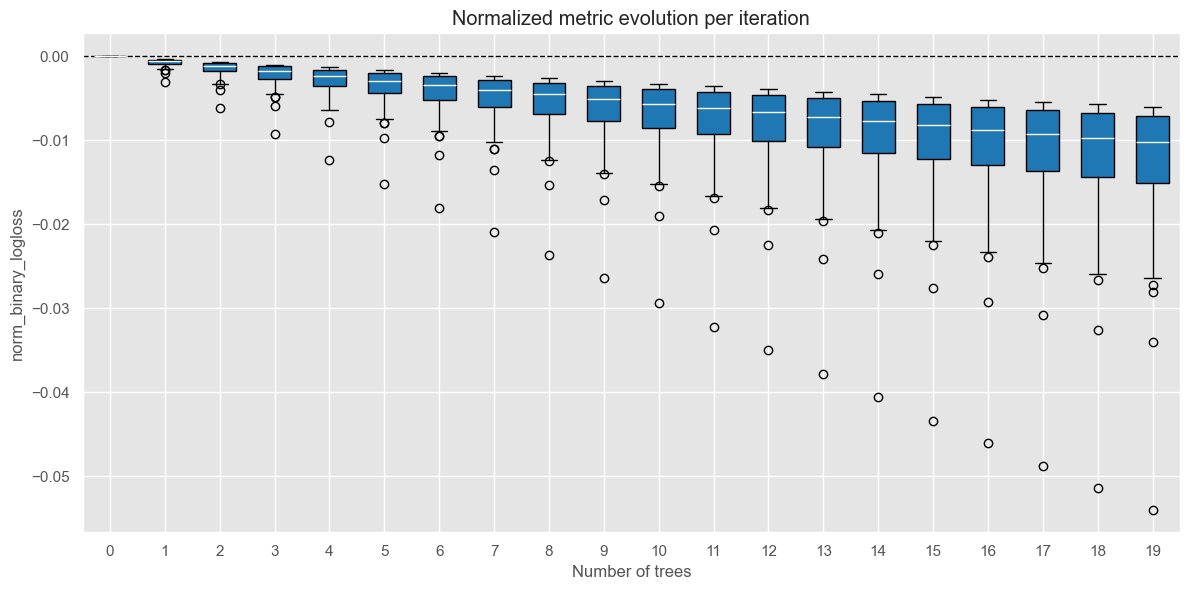

In [118]:
train_lc3 = return_learning_curve('training')
test_lc3 = return_learning_curve('valid_0')
plot_learning_curves_box(train_lc3)

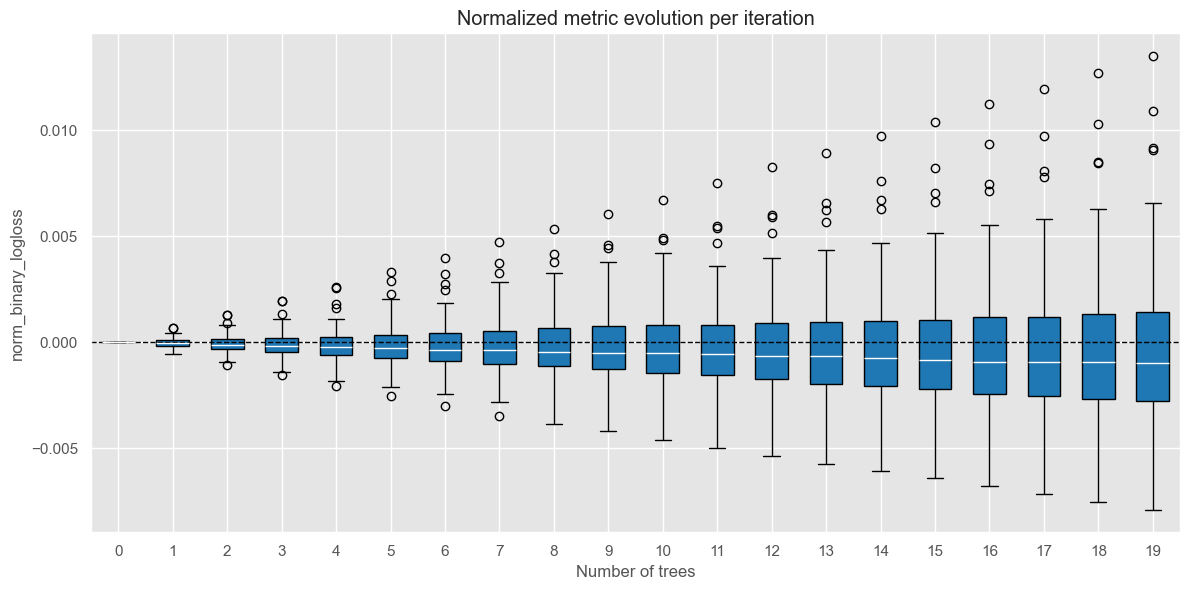

In [119]:
plot_learning_curves_box(test_lc3)

El modelo ahora es un poco peor, pero tiene sentido, ahora no estamos haciendo data leakage

Vamos a comprobar feature importance con este nuevo modelo

In [120]:
params = {
    "random_state":1,
    "verbosity": -1,
    "n_jobs":10,
    "objective": "binary",
    "metric": "binary_logloss",
    "learning_rate": 10e-3,
    "path_smooth":0.2,
    "n_estimators":20
}

all_results = {}
all_predicted_tickers_list = []
all_models = {}
all_permutation_importances = pd.DataFrame()

train_model_accross_periods(train_period_frequency=2, compute_importance=True)

2005-06-30T00:00:00.000000000
2005-12-30T00:00:00.000000000
2006-06-30T00:00:00.000000000
2006-12-30T00:00:00.000000000
2007-06-30T00:00:00.000000000
2007-12-30T00:00:00.000000000
2008-06-30T00:00:00.000000000
2008-12-30T00:00:00.000000000
2009-06-30T00:00:00.000000000
2009-12-30T00:00:00.000000000
2010-06-30T00:00:00.000000000
2010-12-30T00:00:00.000000000
2011-06-30T00:00:00.000000000
2011-12-30T00:00:00.000000000
2012-06-30T00:00:00.000000000
2012-12-30T00:00:00.000000000
2013-06-30T00:00:00.000000000
2013-12-30T00:00:00.000000000
2014-06-30T00:00:00.000000000
2014-12-30T00:00:00.000000000
2015-06-30T00:00:00.000000000
2015-12-30T00:00:00.000000000
2016-06-30T00:00:00.000000000
2016-12-30T00:00:00.000000000
2017-06-30T00:00:00.000000000
2017-12-30T00:00:00.000000000
2018-06-30T00:00:00.000000000
2018-12-30T00:00:00.000000000
2019-06-30T00:00:00.000000000
2019-12-30T00:00:00.000000000
2020-06-30T00:00:00.000000000
2020-12-30T00:00:00.000000000


In [121]:
all_permutation_importances = all_permutation_importances.sort_values(["execution_date", "importance"], ascending=False)

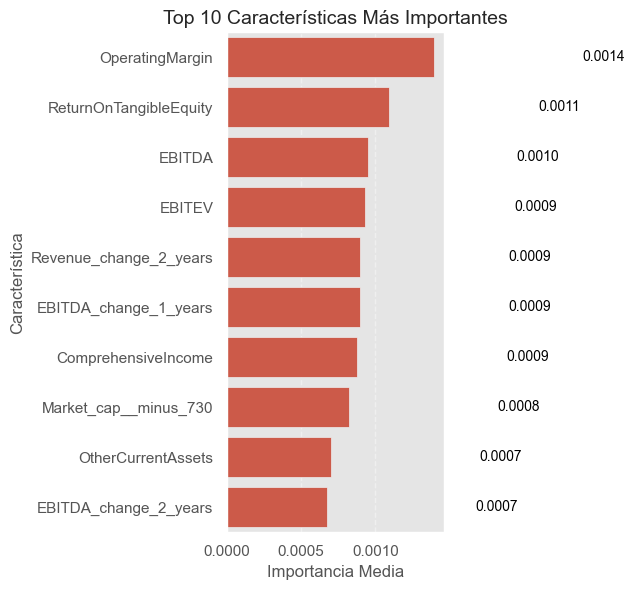

In [122]:
plot_top_features(all_permutation_importances, top_n=10, figsize=(10, 6), title="Top 10 Características Más Importantes")

Estas features tienen más sentido, son features que determinan el valor de una empresa y es normal que el modelo aprenda de ellas

In [123]:
all_permutation_importances["rank"] = all_permutation_importances.groupby(["execution_date"]).cumcount()
r_all_permutation_importances = all_permutation_importances[all_permutation_importances["rank"] < 2]



In [124]:
r_all_permutation_importances = r_all_permutation_importances.sort_values("execution_date")

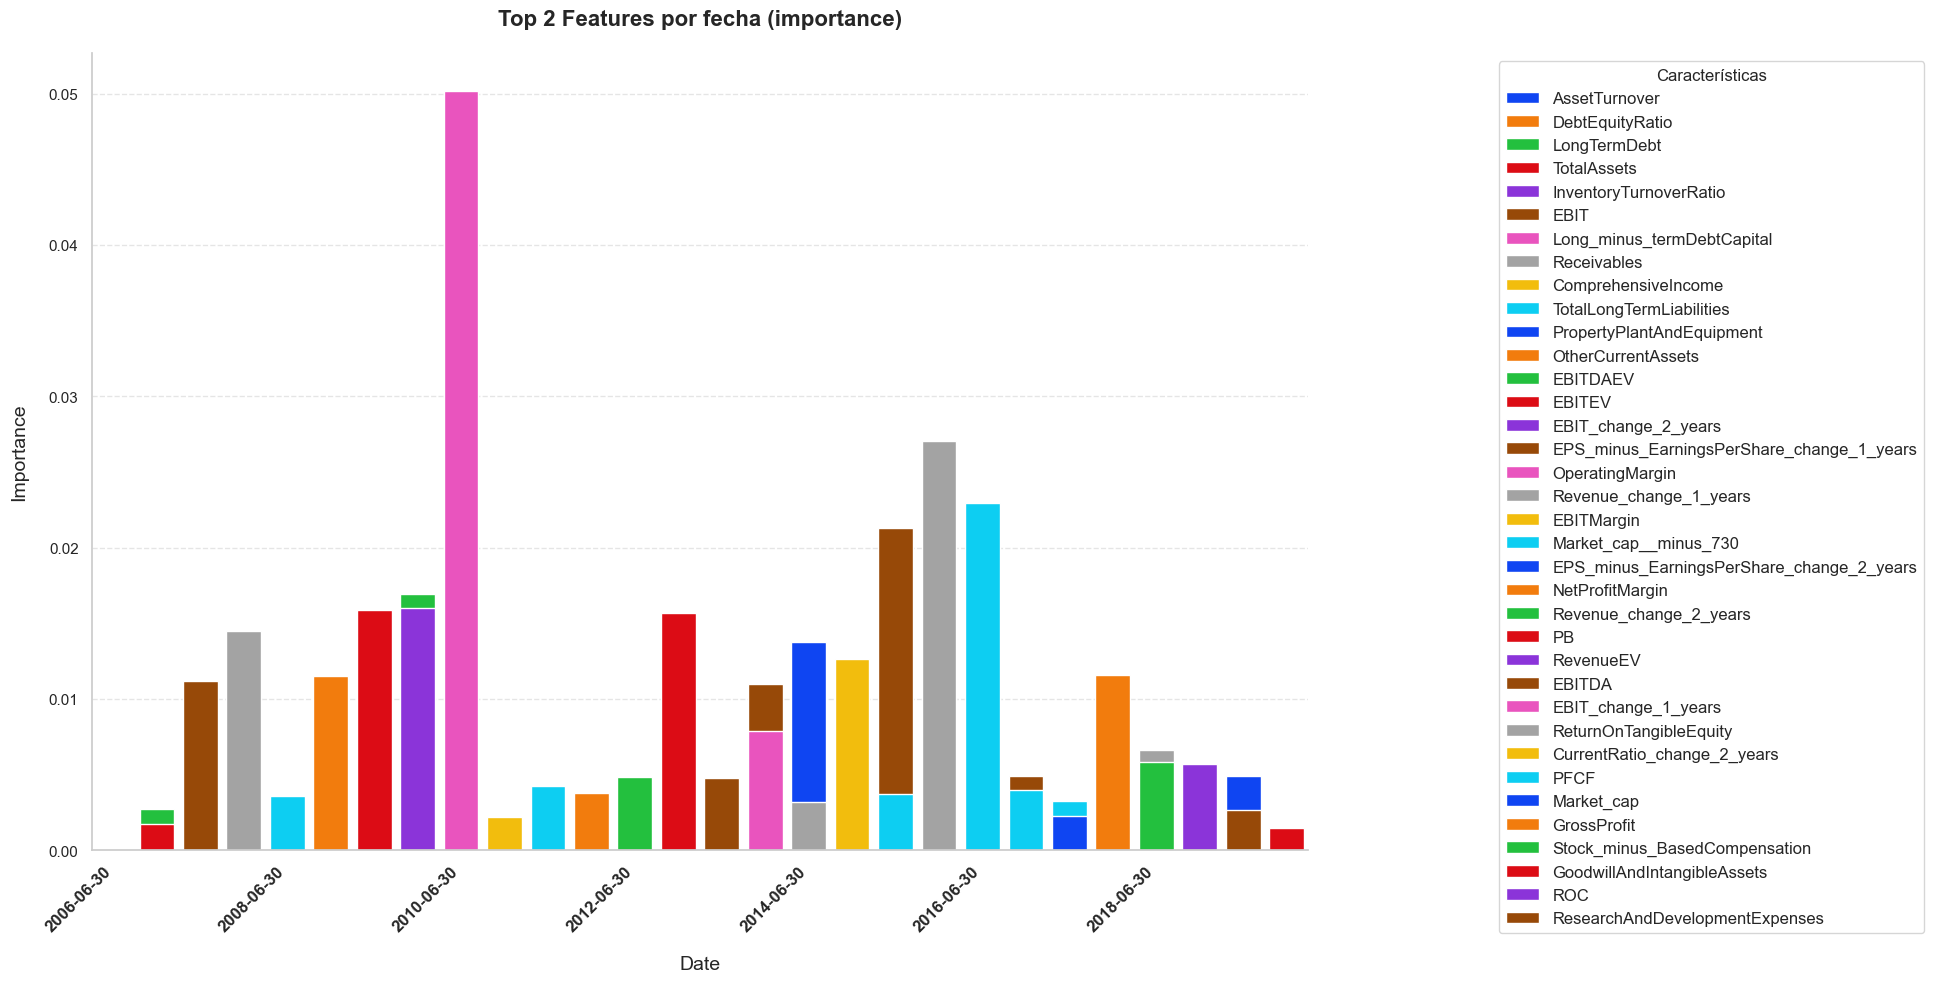

In [125]:
plot_top_2_features(r_all_permutation_importances)

Vemos como en cada periodo hay distintas features con importancia, no hay ninguna que este en muchos periodos con mucha importancia como ocurria antes con close__0

Ahora que ya hemos logrado un modelo sin data leakage y que generaliza, podemos ver como son los resultados en funcion de la metrica de negocio "weighted-return" 

In [ ]:
'''def train_model_accross_periods(train_period_frequency = 1, compute_importance = False):
    global all_results
    global all_predicted_tickers_list
    global all_models
    global all_predicted_tickers
    for i, execution_date in enumerate(execution_dates):
        if i%train_period_frequency==0:
            print(execution_date)
            all_results, all_predicted_tickers_list, all_models, model, X_train, X_test = run_model_for_execution_date(execution_date, all_results, all_predicted_tickers_list, all_models, False,compute_importance)

    all_predicted_tickers = pd.concat(all_predicted_tickers_list)'''

'def train_model_accross_periods(train_period_frequency = 1, compute_importance = False):\n    global all_results\n    global all_predicted_tickers_list\n    global all_models\n    global all_predicted_tickers\n    for i, execution_date in enumerate(execution_dates):\n        if i%train_period_frequency==0:\n            print(execution_date)\n            all_results, all_predicted_tickers_list, all_models, model, X_train, X_test = run_model_for_execution_date(execution_date, all_results, all_predicted_tickers_list, all_models, False,compute_importance)\n\n    all_predicted_tickers = pd.concat(all_predicted_tickers_list)'

Hay que adaptar las funciones para poder comparar con el benchmark

In [126]:
def train_model(train_set,test_set, compute_importance=False):

    global params 
    global model

    columns_to_remove = get_columns_to_remove()
    
    X_train = train_set.drop(columns = columns_to_remove, errors = "ignore")
    X_test = test_set.drop(columns = columns_to_remove, errors = "ignore")
    
    
    y_train = train_set["target"]
    y_test = test_set["target"]

    lgb_train = lgb.Dataset(X_train,y_train)
    lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)
    
    eval_result = {}
    
 
    
    model = lgb.train(params = params,train_set = lgb_train,
                      valid_sets = [lgb_test,lgb_train],
                      feval = [top_wt_performance],
                      callbacks = [lgb.record_evaluation(eval_result = eval_result)])
    return model,eval_result,X_train,X_test, pd.DataFrame()

In [127]:
params = {
    "random_state":1,
    "verbosity": -1,
    "n_jobs":10,
    "objective": "binary",
    "metric": "binary_logloss",
    "learning_rate": 10e-3,
    "path_smooth":0.2,
    "n_estimators":30
}

all_results = {}
all_predicted_tickers_list = []
all_models = {}
all_permutation_importances = pd.DataFrame()

train_model_accross_periods(train_period_frequency=1, compute_importance=False)

2005-06-30T00:00:00.000000000
2005-09-30T00:00:00.000000000
2005-12-30T00:00:00.000000000
2006-03-31T00:00:00.000000000
2006-06-30T00:00:00.000000000
2006-09-30T00:00:00.000000000
2006-12-30T00:00:00.000000000
2007-03-31T00:00:00.000000000
2007-06-30T00:00:00.000000000
2007-09-30T00:00:00.000000000
2007-12-30T00:00:00.000000000
2008-03-31T00:00:00.000000000
2008-06-30T00:00:00.000000000
2008-09-30T00:00:00.000000000
2008-12-30T00:00:00.000000000
2009-03-31T00:00:00.000000000
2009-06-30T00:00:00.000000000
2009-09-30T00:00:00.000000000
2009-12-30T00:00:00.000000000
2010-03-31T00:00:00.000000000
2010-06-30T00:00:00.000000000
2010-09-30T00:00:00.000000000
2010-12-30T00:00:00.000000000
2011-03-31T00:00:00.000000000
2011-06-30T00:00:00.000000000
2011-09-30T00:00:00.000000000
2011-12-30T00:00:00.000000000
2012-03-31T00:00:00.000000000
2012-06-30T00:00:00.000000000
2012-09-30T00:00:00.000000000
2012-12-30T00:00:00.000000000
2013-03-31T00:00:00.000000000
2013-06-30T00:00:00.000000000
2013-09-30

In [128]:
test_results = parse_results_into_df("valid_0")
train_results = parse_results_into_df("training")

In [129]:
test_results_final_tree = test_results.sort_values(["execution_date", "n_trees"]).drop_duplicates("execution_date", keep = "last")
train_results_final_tree = train_results.sort_values(["execution_date", "n_trees"]).drop_duplicates("execution_date", keep = "last")

In [130]:
test_results_final_tree = merge_against_benchmark(test_results_final_tree, all_predicted_tickers)

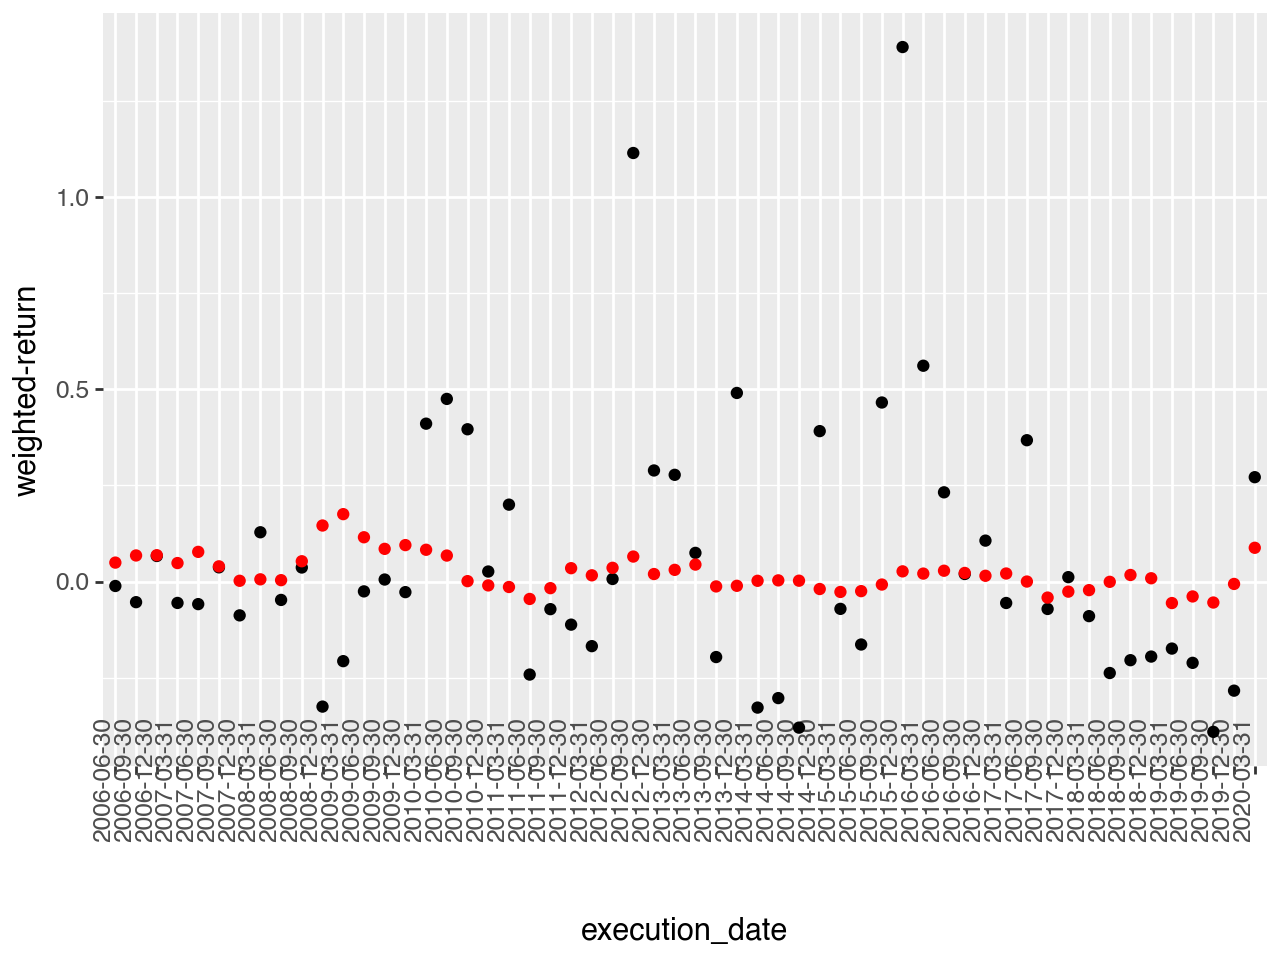

In [131]:
(ggplot(test_results_final_tree[test_results_final_tree["weighted-return"]<2])
+ geom_point(aes(x = "execution_date", y = "weighted-return"), color='black')
+ geom_point(aes(x= "execution_date", y ="diff_ch_sp500_baseline"), color="red")
+ theme(axis_text_x = element_text(angle = 90, vjust = 0.5, hjust=1))
)

% de periodos en los que modelo es mejor que baseline:

In [132]:
periods_better_than_baseline = len(test_results_final_tree[test_results_final_tree['weighted-return']>test_results_final_tree["diff_ch_sp500_baseline"]])/len(test_results_final_tree)
print(f"{periods_better_than_baseline *100:.2f}")

35.71


El primer modelo tenia un % del 70%. Este valor se acerca mucho más a la realidad

Rendimiento de baseline vs modelo

In [133]:
test_results_final_tree["weighted-return"].median()

-0.026677532389133746

In [134]:
test_results_final_tree["diff_ch_sp500_baseline"].median()

0.015525563344158869

In [135]:
test_results_final_tree["weighted-return"].mean()

0.053507209868450825

In [136]:
test_results_final_tree["diff_ch_sp500_baseline"].mean()

0.022159133577893696

Modelo actual:

* Media del retorno es superior al baseline (0.05 vs 0.02). Es decir que el modelo obtiene un 5% de retorno.

* Sin embargo la mediana es menor, de hecho es negativa (-0.02 vs 0.01), esto nos indica que en al menos la mitad de los periodos vamos a perder dinero. Podemos interpretar estos resultados como que el modelo hace apuestas de empresas que van a mejorar al sp500 y normalmente no acierta, pero cuando acierta, obtiene mucho retorno, logrando que la media a lo largo de todos los periodos sea positiva y del 5%.

## Conclusiones

* Feature importance es útil para conocer que está utilizando el modelo para hacer sus predicciones, si las predicciones son malas nos da igual lo que este utilizando, hay que lograr primero un buen modelo.

* En modelos como este, que son complejos y hacen overfitting inicialmnete, hay que simplificar y a partir de ahi añadir capas de complejidad. Hay que probar hiperparametros, especialmente learning_rate, que controla la contribución de un arbol al siguiente.

* Metodos como feature permutation o SHAP son muy valiosos, ya que son agnosticos al modelo que utilicemos
